In [ ]:
import pandas as pd
df = pd.read_parquet('/content/drive/MyDrive/TimeSeries/Data/A-MINUTES1.parquet')
df.head()

open   high    low  close    vol
2010-01-04 17:30:00  31.39  31.48  31.14  31.14    800
2010-01-04 17:31:00  31.41  31.50  31.14  31.36  71502
2010-01-04 17:32:00  31.36  31.36  31.23  31.23  13156
2010-01-04 17:33:00  31.22  31.28  31.21  31.22   9200
2010-01-04 17:34:00  31.23  31.33  31.22  31.28  10357

# Gh√©p d·ªØ li·ªáu

In [ ]:
import pandas as pd
import os
from glob import glob

# ƒê∆∞·ªùng d·∫´n ch·ª©a c√°c file .parquet
data_path = '/content/drive/MyDrive/TimeSeries/data_3'
parquet_files = glob(os.path.join(data_path, '*.parquet'))

# Danh s√°ch l∆∞u t·ª´ng DataFrame
dfs = []

for file_path in parquet_files:
    # Extract ticker t·ª´ t√™n file: VD A-MINUTES1.parquet ‚Üí ticker = "A"
    ticker = os.path.basename(file_path).split('-')[0]
    df = pd.read_parquet(file_path)

    df = df.copy()
    df['ticker'] = ticker  # th√™m c·ªôt ticker
    df.index = pd.to_datetime(df.index)  # ch·∫Øc ch·∫Øn r·∫±ng index l√† datetime

    dfs.append(df)

# G·ªôp t·∫•t c·∫£ l·∫°i
merged_df = pd.concat(dfs)
merged_df = merged_df.sort_index()

print(merged_df.head())


                         open      high       low   close    vol ticker
2010-01-01 00:00:00  411.0800  411.2300  411.0800  411.23   9284   BIDU
2010-01-04 17:30:00   56.8701   56.9200   56.8701   56.92   2400    VTI
2010-01-04 17:30:00  626.6900  629.5100  626.6900  627.89  71321  GOOGL
2010-01-04 17:30:00  415.5000  417.0000  415.5000  416.44  33474   BIDU
2010-01-04 17:31:00   56.9050   56.9484   56.9050   56.93   5900    VTI


In [ ]:
# T·∫°o m√£ s·ªë (int) cho m·ªói ticker (d√πng cho embedding)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
merged_df['ticker_id'] = le.fit_transform(merged_df['ticker'])

# L∆∞u l·∫°i ƒë·ªÉ d√πng trong m√¥ h√¨nh
ticker2id = dict(zip(le.classes_, le.transform(le.classes_)))
id2ticker = dict(zip(le.transform(le.classes_), le.classes_))

print("Mapping ticker ‚Üí ID:", ticker2id)


Mapping ticker ‚Üí ID: {'BIDU': np.int64(0), 'GOOGL': np.int64(1), 'VTI': np.int64(2)}


In [ ]:
merged_df.head()

open    high       low   close     vol ticker  \
2010-01-01 00:00:00  411.0800  411.23  411.0800  411.23    9284   BIDU   
2010-01-01 00:00:00  111.5100  111.51  111.4500  111.46  127508    SPY   
2010-01-04 17:30:00  136.1500  136.40  135.7600  135.87   61657   AMZN   
2010-01-04 17:30:00  415.5000  417.00  415.5000  416.44   33474   BIDU   
2010-01-04 17:30:00   56.8701   56.92   56.8701   56.92    2400    VTI   

                     ticker_id  
2010-01-01 00:00:00          1  
2010-01-01 00:00:00          3  
2010-01-04 17:30:00          0  
2010-01-04 17:30:00          1  
2010-01-04 17:30:00          4

# T·∫°o ƒë·∫ßu v√†o cho m√¥ h√¨nh

In [ ]:
import numpy as np

def create_sequences(data, window_size=30):
    X, y, tickers = [], [], []
    for ticker_id in data['ticker_id'].unique():
        df_ticker = data[data['ticker_id'] == ticker_id]

        close_values = df_ticker['close'].values
        for i in range(len(close_values) - window_size):
            X.append(close_values[i:i+window_size])
            y.append(close_values[i+window_size])
            tickers.append(ticker_id)

    return np.array(X), np.array(y), np.array(tickers)

X, y, ticker_ids = create_sequences(merged_df, window_size=30)

# Reshape l·∫°i
X_price = X[..., np.newaxis]             # (samples, 60, 1)
X_ticker = ticker_ids[:, np.newaxis]     # (samples, 1)


In [ ]:
print(X)

[[ 411.23    416.44    416.83   ...  411.89    412.82    412.3001]
 [ 416.44    416.83    415.44   ...  412.82    412.3001  412.8   ]
 [ 416.83    415.44    414.08   ...  412.3001  412.8     413.12  ]
 ...
 [1758.38   1758.05   1757.85   ... 1759.58   1758.01   1757.    ]
 [1758.05   1757.85   1758.09   ... 1758.01   1757.     1757.12  ]
 [1757.85   1758.09   1756.22   ... 1757.     1757.12   1753.12  ]]


# M√¥ h√¨nh

In [ ]:
!pip install keras_tuner

In [ ]:
# 1. Import th∆∞ vi·ªán
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import matplotlib.pyplot as plt

# 2. ƒê·ªçc & g·ªôp d·ªØ li·ªáu t·ª´ c√°c file parquet
files = glob.glob('/content/drive/MyDrive/TimeSeries/Demo_Data_5/*.parquet')
dfs = []

for file in files:
    ticker = file.split('/')[-1].split('-')[0]
    df = pd.read_parquet(file)
    df['ticker'] = ticker
    df = df.reset_index().rename(columns={'index': 'datetime'})
    dfs.append(df)

merged_df = pd.concat(dfs).sort_values(by=['ticker', 'datetime']).reset_index(drop=True)

# 3. M√£ ho√° ticker
le = LabelEncoder()
merged_df['ticker_id'] = le.fit_transform(merged_df['ticker'])
ticker_vocab_size = merged_df['ticker_id'].nunique()

# 4. T·∫°o sliding window
def create_sequences(data, window_size=60):
    X, y, tickers = [], [], []
    for ticker_id in data['ticker_id'].unique():
        df_ticker = data[data['ticker_id'] == ticker_id]
        close_values = df_ticker['close'].values
        for i in range(len(close_values) - window_size):
            X.append(close_values[i:i+window_size])
            y.append(close_values[i+window_size])
            tickers.append(ticker_id)
    return np.array(X), np.array(y), np.array(tickers)

X, y, ticker_ids = create_sequences(merged_df, window_size=60)
X_price = X[..., np.newaxis]            # shape: (samples, 60, 1)
X_ticker = ticker_ids[:, np.newaxis]    # shape: (samples, 1)

# 5. Chia train/test
# X_train_price, X_test_price, X_train_ticker, X_test_ticker, y_train, y_test = train_test_split(
#     X_price, X_ticker, y, test_size=0.2, random_state=42
# )
def split_by_time_per_ticker(X_price, y, X_ticker, test_ratio=0.2):
    """
    Chia d·ªØ li·ªáu theo th·ªùi gian cho t·ª´ng m√£ c·ªï phi·∫øu.

    Parameters:
        - X_price: np.array, shape (samples, window_size, 1)
        - y: np.array, shape (samples,)
        - X_ticker: np.array, shape (samples, 1)
        - test_ratio: float, t·ª∑ l·ªá test (vd: 0.2)

    Returns:
        - X_train_price, X_test_price
        - X_train_ticker, X_test_ticker
        - y_train, y_test
    """
    X_train_price, X_test_price = [], []
    X_train_ticker, X_test_ticker = [], []
    y_train, y_test = [], []

    unique_tickers = np.unique(X_ticker)

    for ticker_id in unique_tickers:
        idx = np.where(X_ticker.flatten() == ticker_id)[0]

        # Gi·ªØ nguy√™n th·ª© t·ª± th·ªùi gian
        ticker_X_price = X_price[idx]
        ticker_y = y[idx]
        ticker_X_ticker = X_ticker[idx]

        split_idx = int(len(idx) * (1 - test_ratio))

        X_train_price.append(ticker_X_price[:split_idx])
        X_test_price.append(ticker_X_price[split_idx:])
        y_train.append(ticker_y[:split_idx])
        y_test.append(ticker_y[split_idx:])
        X_train_ticker.append(ticker_X_ticker[:split_idx])
        X_test_ticker.append(ticker_X_ticker[split_idx:])

    # N·ªëi t·∫•t c·∫£ l·∫°i
    return (
        np.concatenate(X_train_price),
        np.concatenate(X_test_price),
        np.concatenate(X_train_ticker),
        np.concatenate(X_test_ticker),
        np.concatenate(y_train),
        np.concatenate(y_test)
    )

# G·ªçi h√†m
X_train_price, X_test_price, X_train_ticker, X_test_ticker, y_train, y_test = split_by_time_per_ticker(
    X_price, y, X_ticker, test_ratio=0.2
)


# 6. ƒê·ªãnh nghƒ©a m√¥ h√¨nh
def build_model(hp):
    time_steps = X_train_price.shape[1]

    embedding_dim = hp.Int("embedding_dim", 4, 32, step=4)
    lstm_units = hp.Int("lstm_units", 32, 128, step=16)
    dense_units = hp.Int("dense_units", 32, 128, step=16)
    dropout_rate = hp.Float("dropout", 0.1, 0.5, step=0.1)
    learning_rate = hp.Choice("lr", [1e-2, 1e-3, 1e-4])

    price_input = Input(shape=(time_steps, 1), name="price_input")
    ticker_input = Input(shape=(1,), name="ticker_input")

    ticker_embedding = Embedding(input_dim=ticker_vocab_size, output_dim=embedding_dim)(ticker_input)
    ticker_embedding_flat = Flatten()(ticker_embedding)

    x = LSTM(units=lstm_units)(price_input)
    x = Dropout(dropout_rate)(x)

    x = Concatenate()([x, ticker_embedding_flat])
    x = Dense(dense_units, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=[price_input, ticker_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mse', metrics=['mae'])
    return model

In [ ]:
# 7. Tuner hyperparameter
tuner = kt.RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=3,
    executions_per_trial=1,
    directory="lstm_dic",
    project_name="stock_forecast"
)

tuner.search(
    [X_train_price, X_train_ticker],
    y_train,
    validation_data=([X_test_price, X_test_ticker], y_test),
    epochs=3,
    batch_size=64
)

# 8. Build m√¥ h√¨nh t·ªët nh·∫•t
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)

Trial 3 Complete [00h 25m 24s]
val_mae: 178.3273162841797

Best val_mae So Far: 178.3273162841797
Total elapsed time: 01h 19m 54s


In [ ]:
print("C√°c si√™u tham s·ªë t·ªët nh·∫•t t√¨m ƒë∆∞·ª£c b·ªüi Keras Tuner:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")


C√°c si√™u tham s·ªë t·ªët nh·∫•t t√¨m ƒë∆∞·ª£c b·ªüi Keras Tuner:
embedding_dim: 8
lstm_units: 64
dense_units: 80
dropout: 0.4
lr: 0.001


In [ ]:
# best_hps = tuner.get_best_hyperparameters(1)[0]

# V√≠ d·ª• l∆∞u best_hps d∆∞·ªõi d·∫°ng dict v√†o json
import json

with open('/content/drive/MyDrive/TimeSeries/test/best1_hps.json', 'w') as f:
    json.dump(best_hps.values, f)


In [ ]:
def build_model_manual():
    time_steps = X_train_price.shape[1]

    embedding_dim = 8
    lstm_units = 64
    dense_units = 64
    dropout_rate = 0.3
    learning_rate = 1e-3

    price_input = Input(shape=(time_steps, 1), name="price_input")
    ticker_input = Input(shape=(1,), name="ticker_input")

    ticker_embedding = Embedding(input_dim=ticker_vocab_size, output_dim=embedding_dim)(ticker_input)
    ticker_embedding_flat = Flatten()(ticker_embedding)

    x = LSTM(units=lstm_units)(price_input)
    x = Dropout(dropout_rate)(x)

    x = Concatenate()([x, ticker_embedding_flat])
    x = Dense(dense_units, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=[price_input, ticker_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mse', metrics=['mae'])
    return model


In [ ]:
best_model = build_model_manual()

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = best_model.fit(
    [X_train_price, X_train_ticker],
    y_train,
    validation_data=([X_test_price, X_test_ticker], y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/10
62659/62659 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 514s 8ms/step - loss: 3817.4846 - mae: 21.1591 - val_loss: 179337.4531 - val_mae: 166.5263
Epoch 2/10
62659/62659 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 532s 8ms/step - loss: 492.0095 - mae: 13.0096 - val_loss: 196680.1250 - val_mae: 179.3721
Epoch 3/10
62659/62659 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 500s 8ms/step - loss: 548.8492 - mae: 13.4315 - val_loss: 188607.0000 - val_mae: 182.8398


In [ ]:
# 9. Train m√¥ h√¨nh t·ªët nh·∫•t v·ªõi EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = best_model.fit(
    [X_train_price, X_train_ticker],
    y_train,
    validation_data=([X_test_price, X_test_ticker], y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)

# 10. L∆∞u m√¥ h√¨nh
best_model.save("best_lstm_model.h5")

Epoch 1/10
62659/62659 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 526s 8ms/step - loss: 52269.7383 - mae: 74.5043 - val_loss: 171.2439 - val_mae: 5.7552
Epoch 2/10
62659/62659 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 554s 8ms/step - loss: 1214.4020 - mae: 20.6609 - val_loss: 101.3177 - val_mae: 5.7787
Epoch 3/10
62659/62659 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 539s 9ms/step - loss: 1176.8092 - mae: 20.1604 - val_loss: 282.7891 - val_mae: 10.6967
Epoch 4/10
62659/62659 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 537s 9ms/step - loss: 1134.0355 - mae: 19.8324 - val_loss: 46.3177 - val_mae: 3.1865
Epoch 5/10
62659/62659 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 558s 9ms/step - loss: 1091.9666 - mae: 19.6964 - val_loss: 131.7218 - val_mae: 7.9475
Epoch 6/10
62659/62659 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 567s 9ms/step - loss: 1039.8309 - mae: 19.2405 - val_loss: 52.680

In [ ]:
# L∆∞u m√¥ h√¨nh d∆∞·ªõi d·∫°ng file .h5
best_model.save("/content/drive/MyDrive/TimeSeries/test/best_lstm_model_vip_1.h5")


In [ ]:
best_model.save("best_lstm_model_vip_2.h5")

31330/31330 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 134s 4ms/step - loss: 339997.4375 - mae: 338.5103
Test MAE: 166.5230


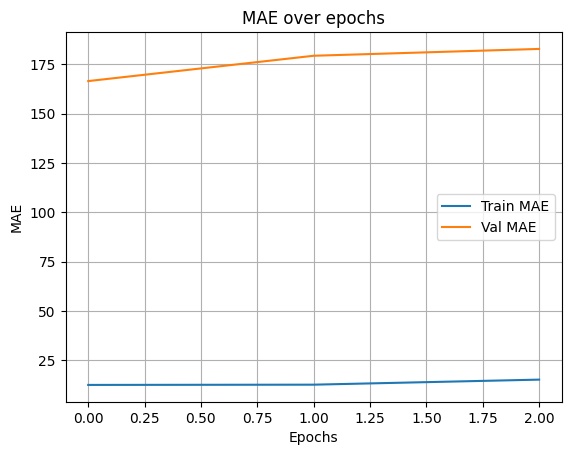

In [ ]:
loss, mae = best_model.evaluate([X_test_price, X_test_ticker], y_test)
print(f"Test MAE: {mae:.4f}")
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("MAE over epochs")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()


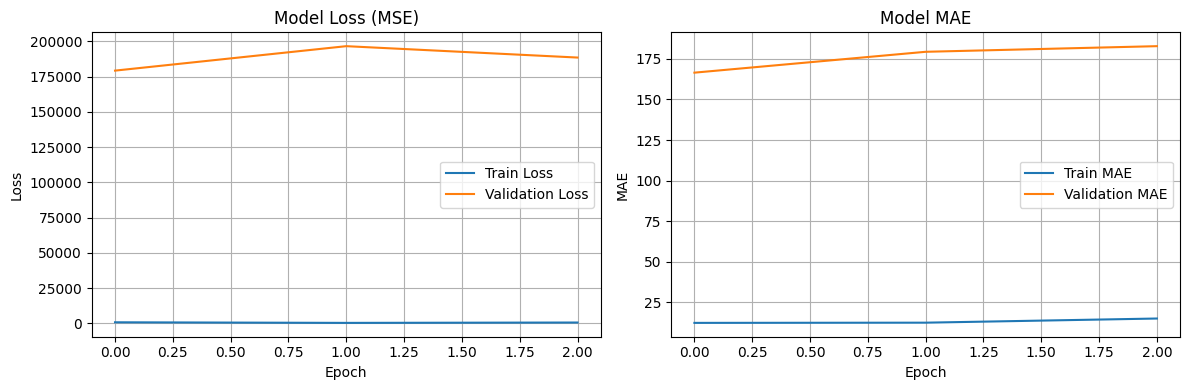

31330/31330 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 86s 3ms/step


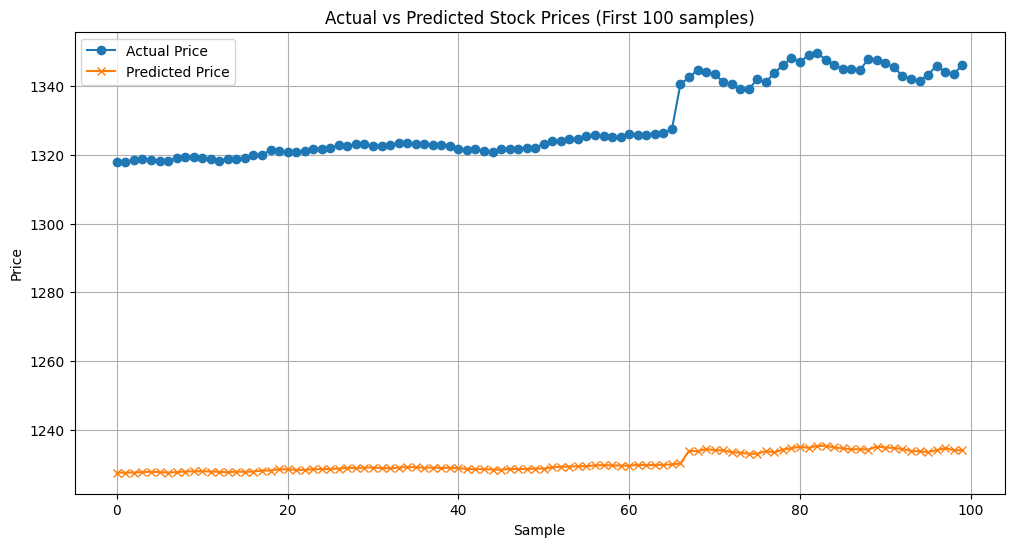

In [ ]:
# 11. Tr·ª±c quan h√≥a k·∫øt qu·∫£

# Bi·ªÉu ƒë·ªì Loss v√† MAE
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Bi·ªÉu ƒë·ªì so s√°nh gi√° d·ª± ƒëo√°n v√† th·ª±c t·∫ø
predictions = best_model.predict([X_test_price, X_test_ticker])

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual Price', marker='o')
plt.plot(predictions[:100], label='Predicted Price', marker='x')
plt.title('Actual vs Predicted Stock Prices (First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

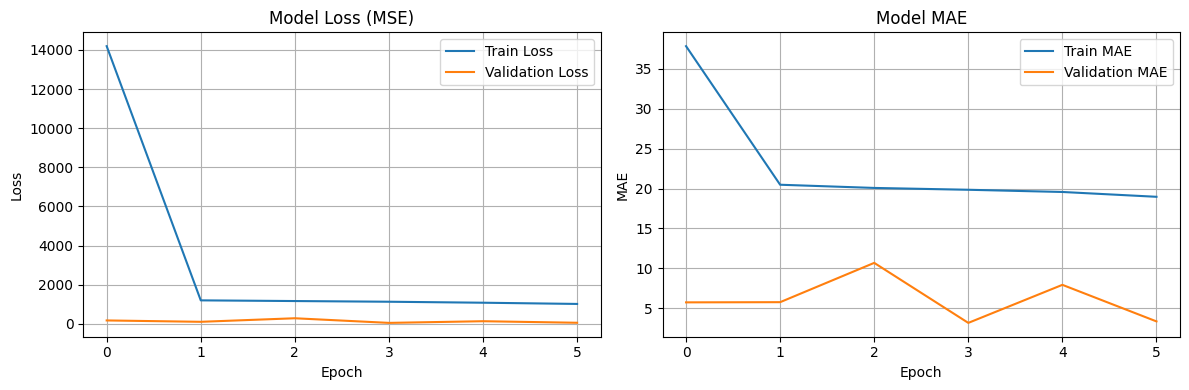

125317/125317 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 347s 3ms/step
31330/31330 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 87s 3ms/step


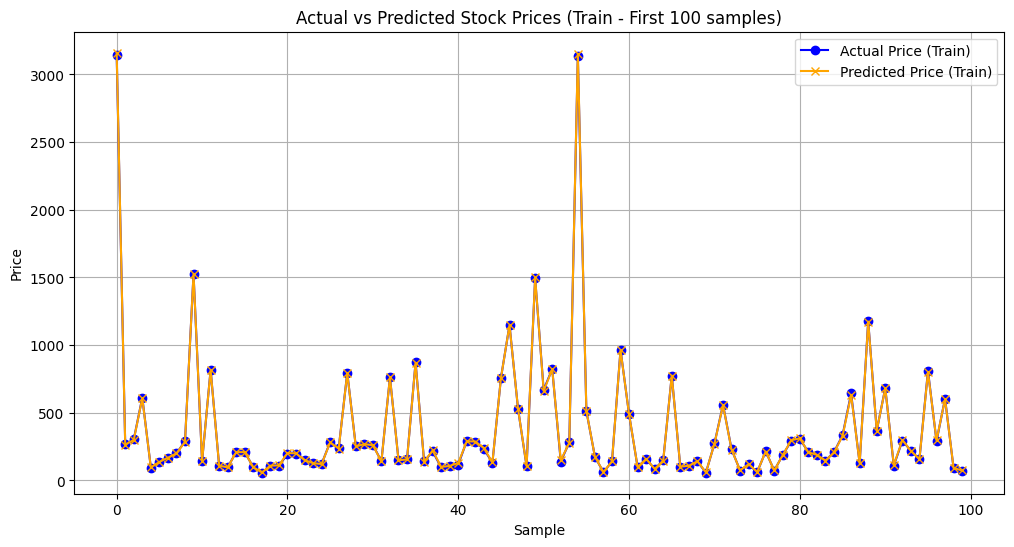

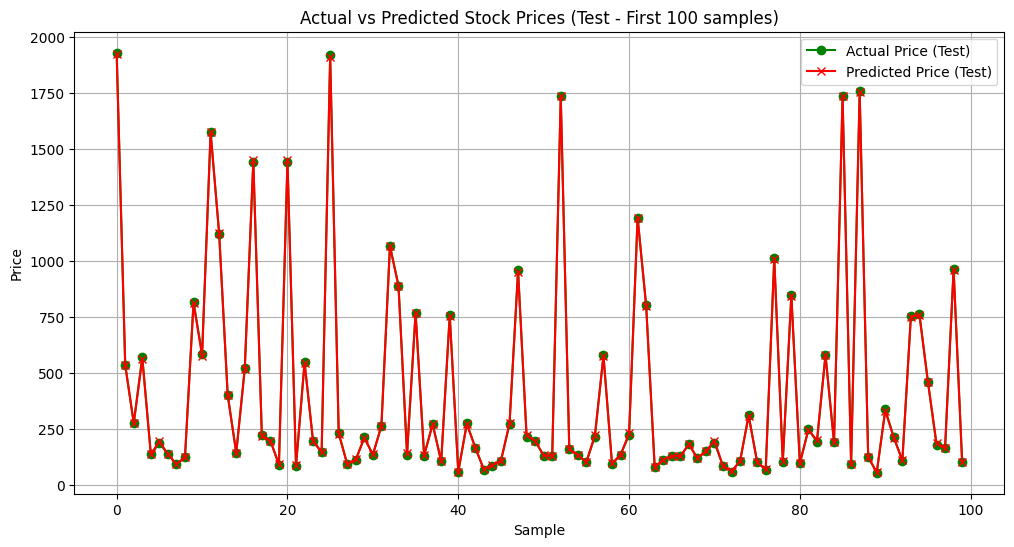

In [ ]:
# 11. Tr·ª±c quan h√≥a k·∫øt qu·∫£

import matplotlib.pyplot as plt

# Bi·ªÉu ƒë·ªì Loss v√† MAE
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# D·ª± ƒëo√°n tr√™n t·∫≠p train v√† test
train_predictions = best_model.predict([X_train_price, X_train_ticker])
test_predictions = best_model.predict([X_test_price, X_test_ticker])

# Bi·ªÉu ƒë·ªì so s√°nh gi√° d·ª± ƒëo√°n v√† th·ª±c t·∫ø cho t·∫≠p train
plt.figure(figsize=(12, 6))
plt.plot(y_train[:100], label='Actual Price (Train)', marker='o', color='blue')
plt.plot(train_predictions[:100], label='Predicted Price (Train)', marker='x', color='orange')
plt.title('Actual vs Predicted Stock Prices (Train - First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Bi·ªÉu ƒë·ªì so s√°nh gi√° d·ª± ƒëo√°n v√† th·ª±c t·∫ø cho t·∫≠p test
plt.figure(figsize=(12, 6))
plt.plot(y_test[100:], label='Actual Price (Test)', marker='o', color='green')
plt.plot(test_predictions[:100], label='Predicted Price (Test)', marker='x', color='red')
plt.title('Actual vs Predicted Stock Prices (Test - First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# === 1. Import th∆∞ vi·ªán ===
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

# === 2. ƒê·ªçc v√† g·ªôp d·ªØ li·ªáu t·ª´ c√°c file parquet ===
files = glob.glob('/content/drive/MyDrive/TimeSeries/Demo_Data_5/*.parquet')
dfs = []

for file in files:
    ticker = file.split('/')[-1].split('-')[0]
    df = pd.read_parquet(file)
    df['ticker'] = ticker
    df = df.reset_index().rename(columns={'index': 'datetime'})
    dfs.append(df)

merged_df = pd.concat(dfs).sort_values(by=['ticker', 'datetime']).reset_index(drop=True)

# === 3. M√£ ho√° ticker ===
le = LabelEncoder()
merged_df['ticker_id'] = le.fit_transform(merged_df['ticker'])
ticker_vocab_size = merged_df['ticker_id'].nunique()

# === 4. T·∫°o sliding window ===
def create_sequences(data, window_size=60):
    X, y, tickers = [], [], []
    for ticker_id in data['ticker_id'].unique():
        df_ticker = data[data['ticker_id'] == ticker_id]
        close_values = df_ticker['close'].values
        for i in range(len(close_values) - window_size):
            X.append(close_values[i:i+window_size])
            y.append(close_values[i+window_size])
            tickers.append(ticker_id)
    return np.array(X), np.array(y), np.array(tickers)

X, y, ticker_ids = create_sequences(merged_df, window_size=60)
X_price = X[..., np.newaxis]            # shape: (samples, 60, 1)
X_ticker = ticker_ids[:, np.newaxis]    # shape: (samples, 1)

# === 5. Chia train/test ===
X_train_price, X_test_price, X_train_ticker, X_test_ticker, y_train, y_test = train_test_split(
    X_price, X_ticker, y, test_size=0.2, random_state=42
)

# === 6. Load m√¥ h√¨nh ƒë√£ hu·∫•n luy·ªán ===
model = load_model("best_lstm_model_vip_2.h5", compile=False)
# model = load_model("/content/drive/MyDrive/TimeSeries/test/best_lstm_model_vip.h5", compile=False)

# # === 7. D·ª± ƒëo√°n tr√™n t·∫≠p train v√† test ===
# y_train_pred = model.predict([X_train_price, X_train_ticker])
# y_test_pred = model.predict([X_test_price, X_test_ticker])

# # === 8. T·∫°o DataFrame k·∫øt qu·∫£ d·ª± ƒëo√°n ===
# train_results = pd.DataFrame({
#     'true': y_train,
#     'pred': y_train_pred.flatten(),
#     'ticker_id': X_train_ticker.flatten(),
#     'dataset': 'train'
# })

# test_results = pd.DataFrame({
#     'true': y_test,
#     'pred': y_test_pred.flatten(),
#     'ticker_id': X_test_ticker.flatten(),
#     'dataset': 'test'
# })

# # G·ªôp l·∫°i
# all_results = pd.concat([train_results, test_results], ignore_index=True)

# # Gi·∫£i m√£ ticker t·ª´ ticker_id
# all_results['ticker'] = le.inverse_transform(all_results['ticker_id'])

# # === 9. Tr·ª±c quan h√≥a k·∫øt qu·∫£ theo t·ª´ng m√£ c·ªï phi·∫øu ===
# tickers = all_results['ticker'].unique()

# for ticker in tickers:
#     fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
#     fig.suptitle(f'Ticker: {ticker}', fontsize=16)

#     for i, ds in enumerate(['train', 'test']):
#         subset = all_results[(all_results['ticker'] == ticker) & (all_results['dataset'] == ds)]
#         axs[i].plot(subset['true'], label='True', color='blue')
#         axs[i].plot(subset['pred'], label='Predicted', color='orange')
#         axs[i].set_title(f'{ds.capitalize()} set')
#         axs[i].set_xlabel('Time Step')
#         axs[i].set_ylabel('Close Price')
#         axs[i].legend()

#     plt.tight_layout()
#     plt.show()

# # === 10. T√≠nh MAE theo ticker (tu·ª≥ ch·ªçn) ===
# mae_by_ticker = all_results.groupby(['ticker', 'dataset']).apply(
#     lambda df: np.mean(np.abs(df['true'] - df['pred']))
# ).reset_index(name='MAE')

# print("\n=== MAE theo t·ª´ng ticker v√† t·∫≠p ===")
# print(mae_by_ticker)


156646/156646 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 427s 3ms/step


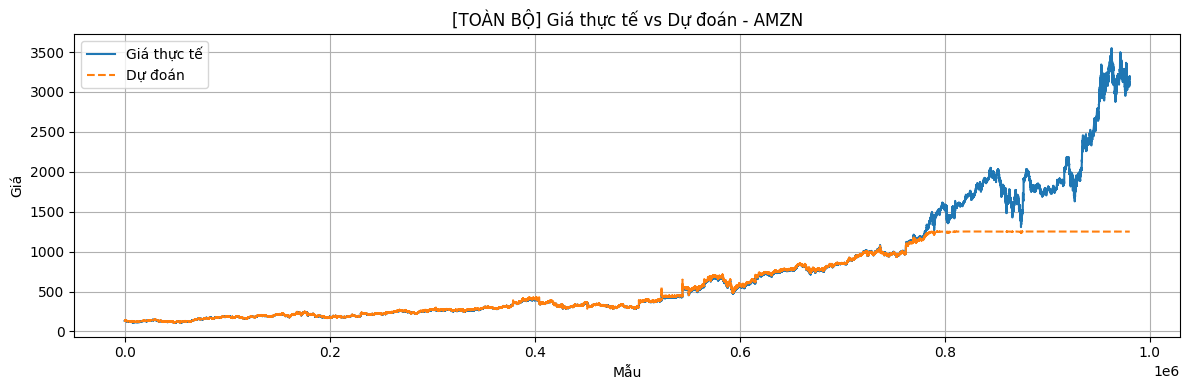

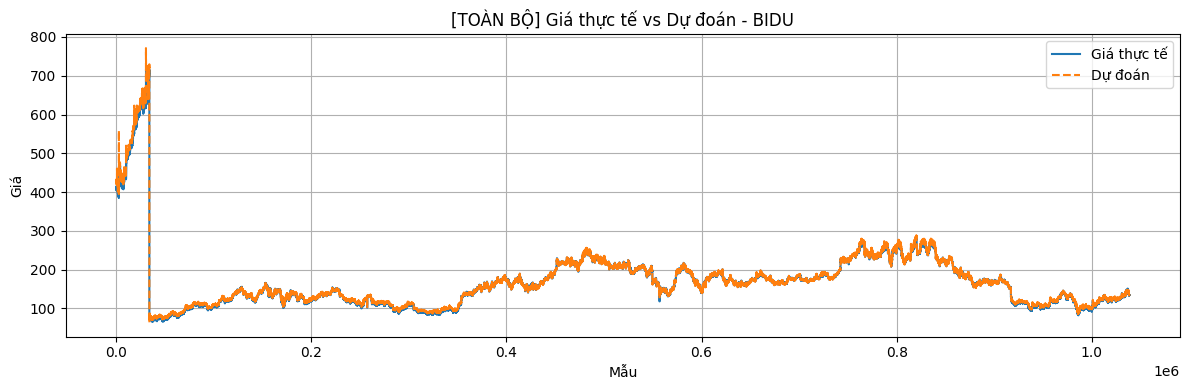

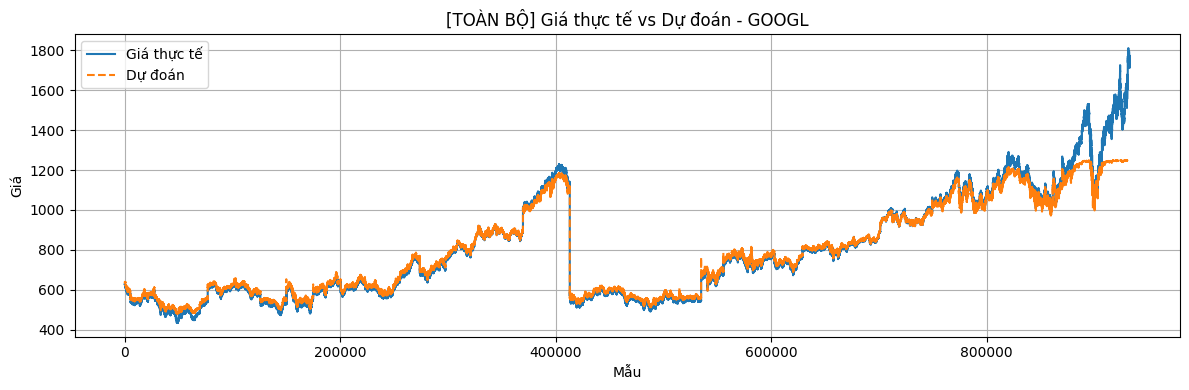

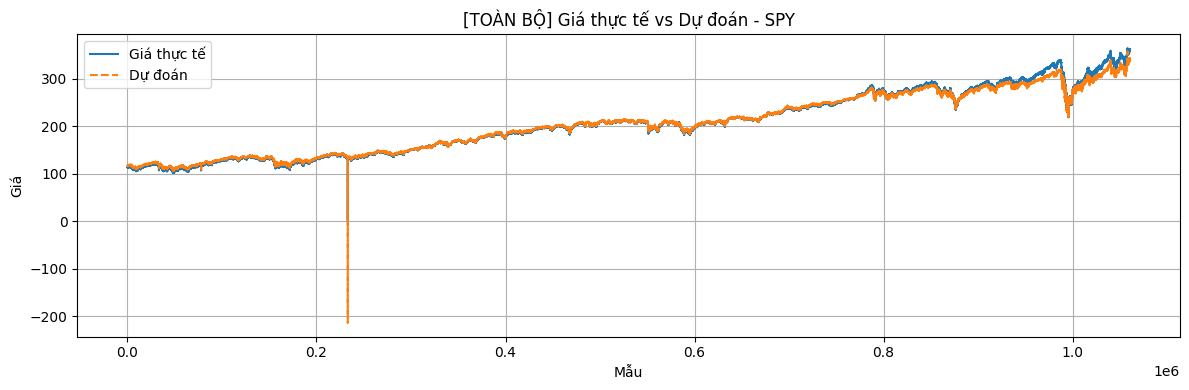

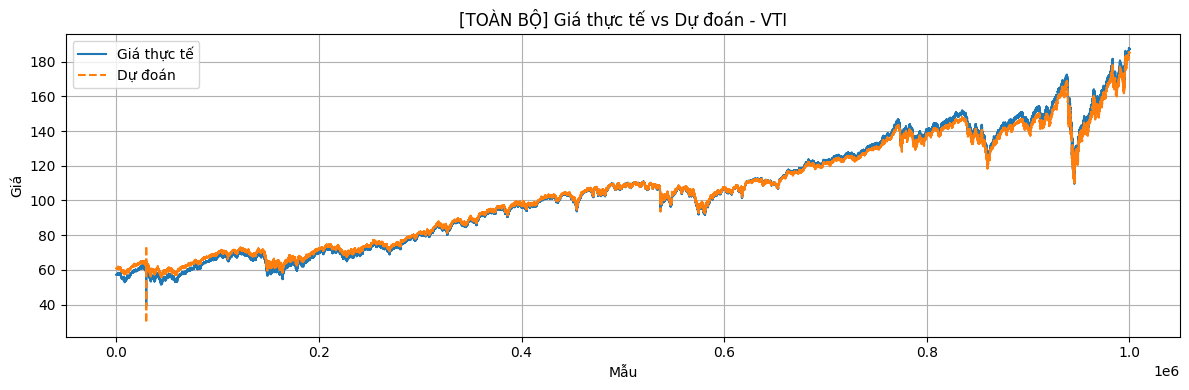

In [ ]:
# === D·ª± ƒëo√°n to√†n b·ªô ===
y_all_pred = model.predict([X_price, X_ticker])

# === T·∫°o DataFrame ch·ª©a k·∫øt qu·∫£ ===
results_all_df = pd.DataFrame({
    'true': y,
    'predicted': y_all_pred.flatten(),
    'ticker_id': X_ticker.flatten()
})

# Gi·∫£i m√£ l·∫°i ticker
results_all_df['ticker'] = le.inverse_transform(results_all_df['ticker_id'])
# V·∫Ω bi·ªÉu ƒë·ªì cho t·ª´ng ticker
unique_tickers = results_all_df['ticker'].unique()

for ticker in unique_tickers:
    df_ticker = results_all_df[results_all_df['ticker'] == ticker].reset_index(drop=True)

    plt.figure(figsize=(12, 4))
    plt.plot(df_ticker.index, df_ticker['true'], label='Gi√° th·ª±c t·∫ø')
    plt.plot(df_ticker.index, df_ticker['predicted'], label='D·ª± ƒëo√°n', linestyle='--')
    plt.title(f"[TO√ÄN B·ªò] Gi√° th·ª±c t·∫ø vs D·ª± ƒëo√°n - {ticker}")
    plt.xlabel("M·∫´u")
    plt.ylabel("Gi√°")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


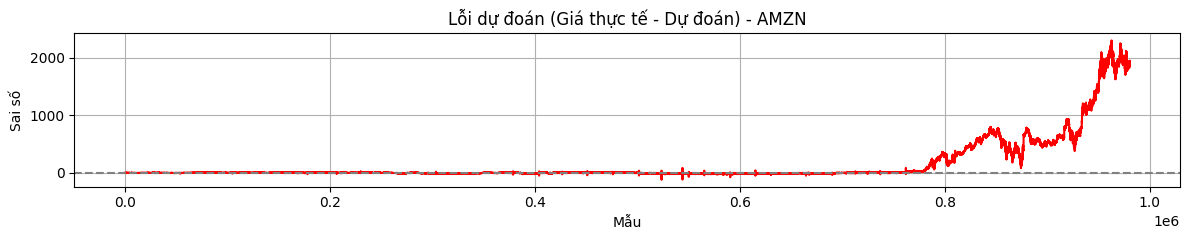

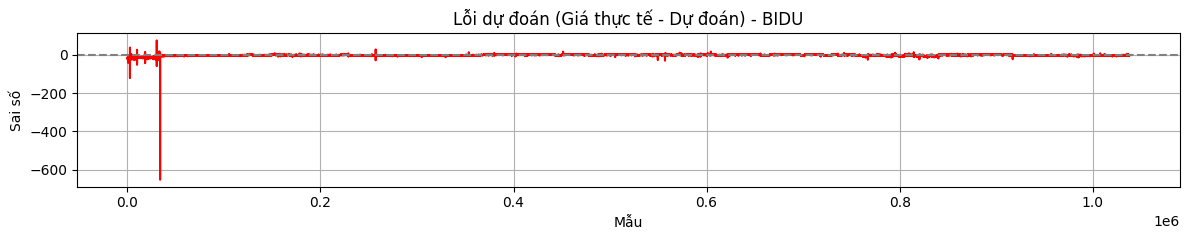

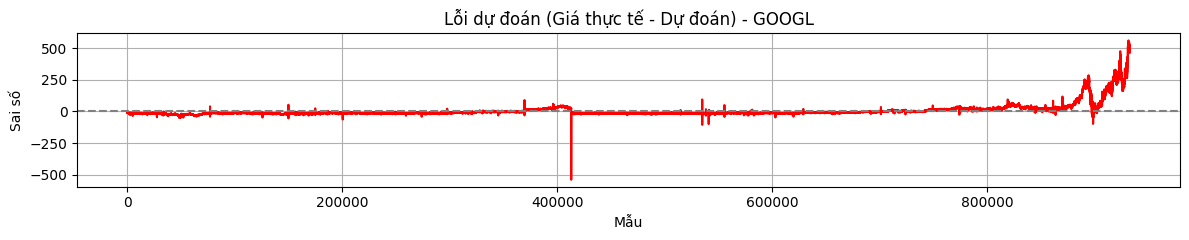

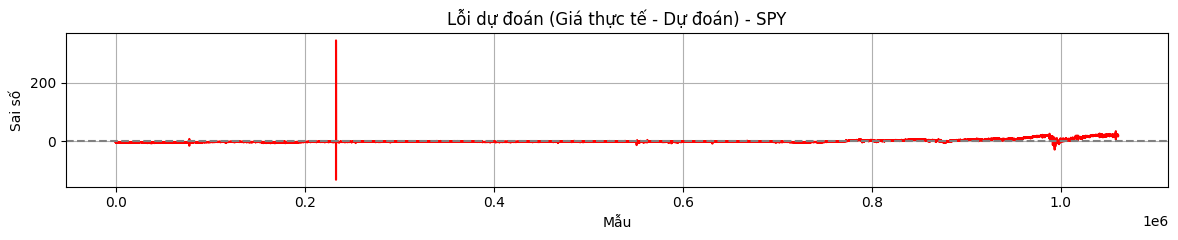

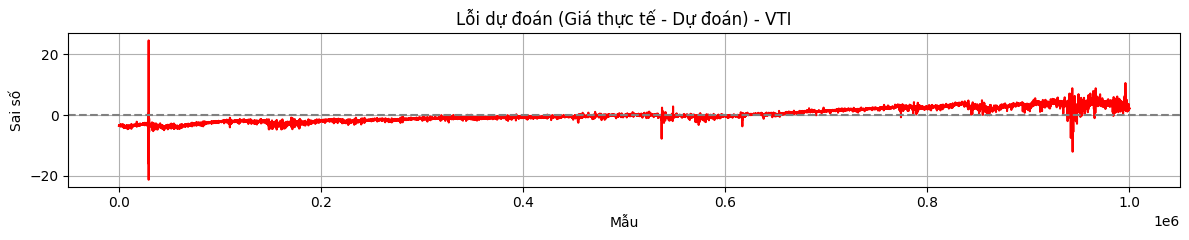

In [ ]:
results_all_df['error'] = results_all_df['true'] - results_all_df['predicted']
for ticker in unique_tickers:
    df_ticker = results_all_df[results_all_df['ticker'] == ticker].reset_index(drop=True)

    # Bi·ªÉu ƒë·ªì l·ªói
    plt.figure(figsize=(12, 2.5))
    plt.plot(df_ticker.index, df_ticker['error'], color='red')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"L·ªói d·ª± ƒëo√°n (Gi√° th·ª±c t·∫ø - D·ª± ƒëo√°n) - {ticker}")
    plt.xlabel("M·∫´u")
    plt.ylabel("Sai s·ªë")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# T√¨m tham s·ªë t·ªët nh·∫•t b·∫±ng Keras tuner

In [ ]:
!pip install keras_tuner

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
# 0. Import th∆∞ vi·ªán
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# 1. H√†m ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu parquet minute stock
def preprocess_stock_minute_data_fast(parquet_folder_path, missing_threshold=0.8):
    print("Step 1: ƒê·ªçc c√°c file parquet trong th∆∞ m·ª•c...")
    files = glob.glob(f"{parquet_folder_path}/*.parquet")
    print(f"  T√¨m th·∫•y {len(files)} file parquet.")

    dfs = []
    for file in files:
        ticker = file.split("/")[-1].split("-")[0]
        print(f"  ƒêang ƒë·ªçc file cho ticker: {ticker}")
        df = pd.read_parquet(file)
        df["ticker"] = ticker
        df = df.reset_index().rename(columns={"index": "datetime"})
        dfs.append(df)

    print("Step 2: G·ªôp d·ªØ li·ªáu t·ª´ c√°c file l·∫°i v√† s·∫Øp x·∫øp...")
    merged_df = pd.concat(dfs).sort_values(by=["ticker", "datetime"]).reset_index(drop=True)
    merged_df["datetime"] = pd.to_datetime(merged_df["datetime"])
    merged_df["date"] = merged_df["datetime"].dt.date
    print(f"  T·ªïng s·ªë d√≤ng sau g·ªôp: {len(merged_df)}")
    print(f"  Kho·∫£ng th·ªùi gian: {merged_df['datetime'].min()} ƒë·∫øn {merged_df['datetime'].max()}")

    print("Step 3: M√£ h√≥a ticker...")
    le = LabelEncoder()
    merged_df["ticker_id"] = le.fit_transform(merged_df["ticker"])
    print(f"  S·ªë l∆∞·ª£ng ticker kh√°c nhau: {merged_df['ticker_id'].nunique()}")

    result = []
    grouped = merged_df.groupby(["ticker", "date"])
    print("Step 4: X·ª≠ l√Ω theo t·ª´ng ticker t·ª´ng ng√†y...")
    for i, ((ticker, date), group) in enumerate(grouped):
        if i % 50 == 0:
            print(f"  ƒêang x·ª≠ l√Ω ticker {ticker}, ng√†y {date}... ({i+1}/{len(grouped)})")

        group = group.set_index("datetime")
        group = group[~group.index.duplicated(keep="first")]

        # T·∫°o index ƒë·∫ßy ƒë·ªß 1 ph√∫t trong kho·∫£ng 17:30 - 23:59
        full_index = pd.date_range(f"{date} 17:30", f"{date} 23:59", freq="1min")
        group = group.reindex(full_index)

        missing_ratio = group["close"].isna().mean()
        if missing_ratio > missing_threshold:
            # B·ªè ng√†y n√†y n·∫øu thi·∫øu qu√° nhi·ªÅu d·ªØ li·ªáu
            continue

        # ƒêi·ªÅn NaN b·∫±ng ffill r·ªìi bfill
        group[["open", "high", "low", "close", "vol"]] = group[["open", "high", "low", "close", "vol"]].ffill()
        group[["open", "high", "low", "close", "vol"]] = group[["open", "high", "low", "close", "vol"]].bfill()

        group["ticker"] = ticker
        group["ticker_id"] = le.transform([ticker])[0]
        group["date"] = date

        result.append(group)

    print("Step 5: Gh√©p c√°c nh√≥m l·∫°i th√†nh dataframe cu·ªëi c√πng...")
    final_df = pd.concat(result).reset_index().rename(columns={"index": "datetime"})

    print(f"Ho√†n th√†nh ti·ªÅn x·ª≠ l√Ω, t·ªïng d√≤ng sau x·ª≠ l√Ω: {len(final_df)}")
    return final_df, le

# 2. Ti·ªÅn x·ª≠ l√Ω, ƒë·ªçc d·ªØ li·ªáu
parquet_path = '/content/drive/MyDrive/TimeSeries/Demo_Data_5'
final_df, label_encoder = preprocess_stock_minute_data_fast(parquet_path)

print("\nTh√¥ng tin chung sau x·ª≠ l√Ω:")
print(" - S·ªë d√≤ng d·ªØ li·ªáu:", len(final_df))
print(" - C√°c ticker c√≥ trong d·ªØ li·ªáu:", final_df['ticker'].unique())
print(" - Kho·∫£ng th·ªùi gian d·ªØ li·ªáu:", final_df['datetime'].min(), "->", final_df['datetime'].max())

# 3. H√†m t·∫°o sequences sliding window
def create_sequences(data, window_size=60):
    X, y, tickers = [], [], []
    for ticker_id in data['ticker_id'].unique():
        df_ticker = data[data['ticker_id'] == ticker_id]
        close_values = df_ticker['close'].values
        for i in range(len(close_values) - window_size):
            X.append(close_values[i:i+window_size])
            y.append(close_values[i+window_size])
            tickers.append(ticker_id)
    return np.array(X), np.array(y), np.array(tickers)

X, y, ticker_ids = create_sequences(final_df, window_size=60)
X_price = X[..., np.newaxis]          # shape (samples, 60, 1)
X_ticker = ticker_ids[:, np.newaxis] # shape (samples, 1)

# 4. H√†m t√°ch train/test theo t·ª´ng ticker gi·ªØ th·ª© t·ª± th·ªùi gian
def split_by_time_per_ticker(X_price, y, X_ticker, test_ratio=0.2):
    X_train_price, X_test_price = [], []
    X_train_ticker, X_test_ticker = [], []
    y_train, y_test = [], []

    unique_tickers = np.unique(X_ticker)

    for ticker_id in unique_tickers:
        idx = np.where(X_ticker.flatten() == ticker_id)[0]

        # Gi·ªØ nguy√™n th·ª© t·ª± th·ªùi gian
        ticker_X_price = X_price[idx]
        ticker_y = y[idx]
        ticker_X_ticker = X_ticker[idx]

        split_idx = int(len(idx) * (1 - test_ratio))

        X_train_price.append(ticker_X_price[:split_idx])
        X_test_price.append(ticker_X_price[split_idx:])
        y_train.append(ticker_y[:split_idx])
        y_test.append(ticker_y[split_idx:])
        X_train_ticker.append(ticker_X_ticker[:split_idx])
        X_test_ticker.append(ticker_X_ticker[split_idx:])

    return (
        np.concatenate(X_train_price),
        np.concatenate(X_test_price),
        np.concatenate(X_train_ticker),
        np.concatenate(X_test_ticker),
        np.concatenate(y_train),
        np.concatenate(y_test)
    )

X_train_price, X_test_price, X_train_ticker, X_test_ticker, y_train, y_test = split_by_time_per_ticker(
    X_price, y, X_ticker, test_ratio=0.2
)

# 5. L·∫•y vocab size c·ªßa ticker t·ª´ label_encoder
ticker_vocab_size = len(label_encoder.classes_)

# 6. ƒê·ªãnh nghƒ©a m√¥ h√¨nh v·ªõi Keras Tuner
def build_model(hp):
    time_steps = X_train_price.shape[1]

    embedding_dim = hp.Int("embedding_dim", 4, 32, step=4)
    lstm_units = hp.Int("lstm_units", 32, 128, step=16)
    dense_units = hp.Int("dense_units", 32, 128, step=16)
    dropout_rate = hp.Float("dropout", 0.1, 0.5, step=0.1)
    learning_rate = hp.Choice("lr", [1e-2, 1e-3, 1e-4])

    price_input = Input(shape=(time_steps, 1), name="price_input")
    ticker_input = Input(shape=(1,), name="ticker_input")

    ticker_embedding = Embedding(input_dim=ticker_vocab_size, output_dim=embedding_dim)(ticker_input)
    ticker_embedding_flat = Flatten()(ticker_embedding)

    x = LSTM(units=lstm_units)(price_input)
    x = Dropout(dropout_rate)(x)

    x = Concatenate()([x, ticker_embedding_flat])
    x = Dense(dense_units, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=[price_input, ticker_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mse', metrics=['mae'])
    return model



Step 1: ƒê·ªçc c√°c file parquet trong th∆∞ m·ª•c...
  T√¨m th·∫•y 5 file parquet.
  ƒêang ƒë·ªçc file cho ticker: AMZN
  ƒêang ƒë·ªçc file cho ticker: BIDU
  ƒêang ƒë·ªçc file cho ticker: GOOGL
  ƒêang ƒë·ªçc file cho ticker: SPY
  ƒêang ƒë·ªçc file cho ticker: VTI
Step 2: G·ªôp d·ªØ li·ªáu t·ª´ c√°c file l·∫°i v√† s·∫Øp x·∫øp...
  T·ªïng s·ªë d√≤ng sau g·ªôp: 5012961
  Kho·∫£ng th·ªùi gian: 2010-01-01 00:00:00 ƒë·∫øn 2020-11-25 23:59:00
Step 3: M√£ h√≥a ticker...
  S·ªë l∆∞·ª£ng ticker kh√°c nhau: 5
Step 4: X·ª≠ l√Ω theo t·ª´ng ticker t·ª´ng ng√†y...
  ƒêang x·ª≠ l√Ω ticker AMZN, ng√†y 2010-01-04... (1/14701)
  ƒêang x·ª≠ l√Ω ticker AMZN, ng√†y 2010-03-17... (51/14701)
  ƒêang x·ª≠ l√Ω ticker AMZN, ng√†y 2010-05-27... (101/14701)
  ƒêang x·ª≠ l√Ω ticker AMZN, ng√†y 2010-08-09... (151/14701)
  ƒêang x·ª≠ l√Ω ticker AMZN, ng√†y 2010-10-19... (201/14701)
  ƒêang x·ª≠ l√Ω ticker AMZN, ng√†y 2010-12-30... (251/14701)
  ƒêang x·ª≠ l√Ω ticker AMZN, ng√†y 2011-03-14... (301/14701)
  ƒêang x·

In [ ]:
# 7. Tuner t√¨m ki·∫øm hyperparameter t·ªët nh·∫•t
tuner = kt.RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=3,
    executions_per_trial=1,
    directory="lstm_dic",
    project_name="stock_forecast"
)

tuner.search(
    [X_train_price, X_train_ticker],
    y_train,
    validation_data=([X_test_price, X_test_ticker], y_test),
    epochs=3,
    batch_size=64
)



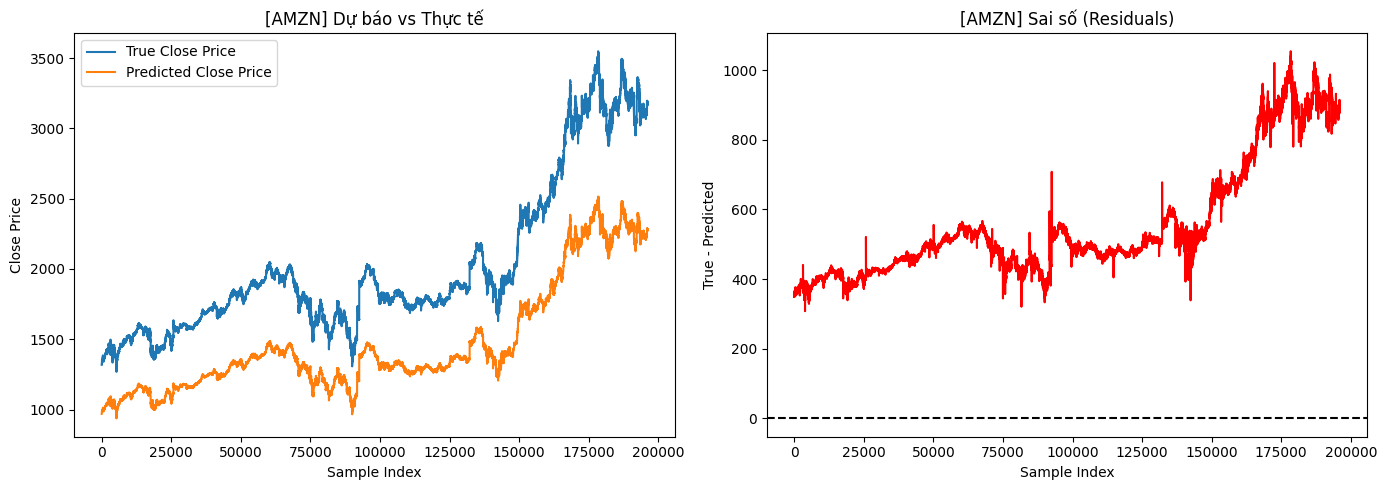

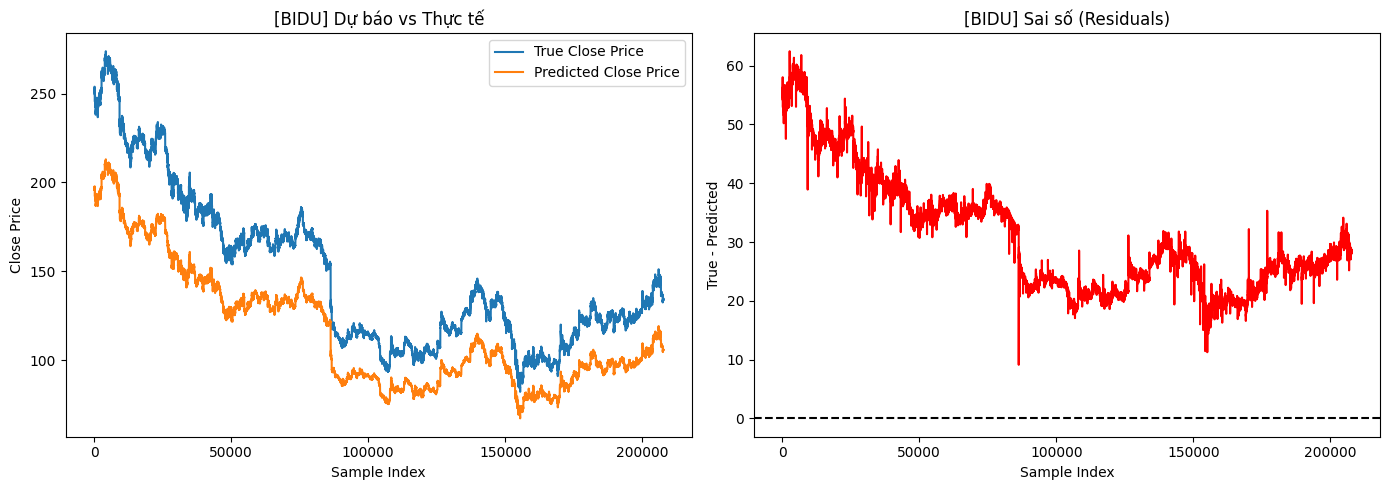

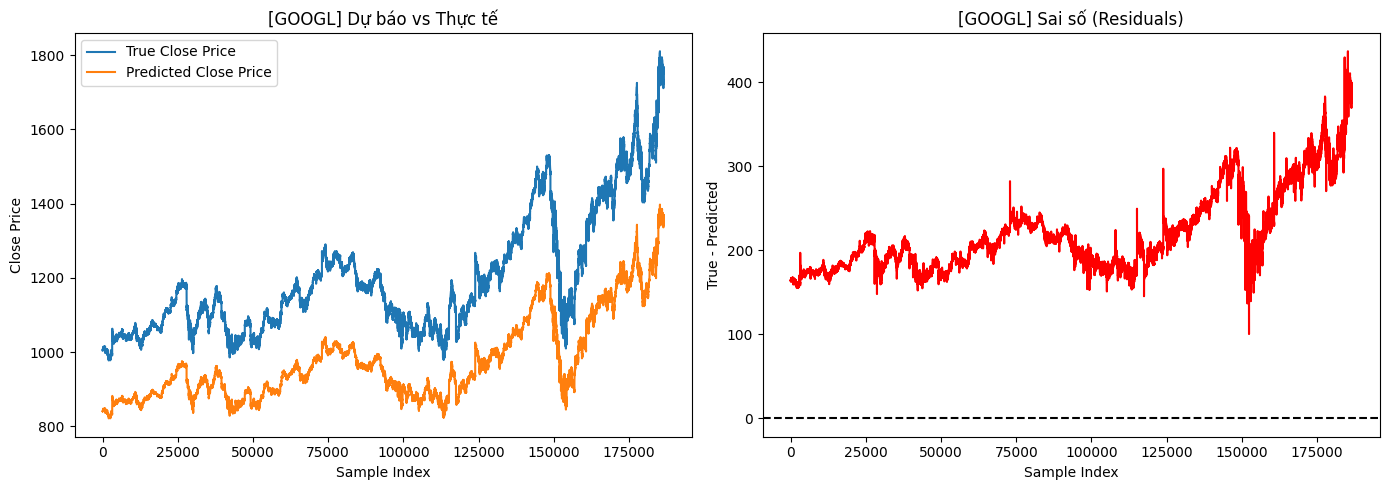

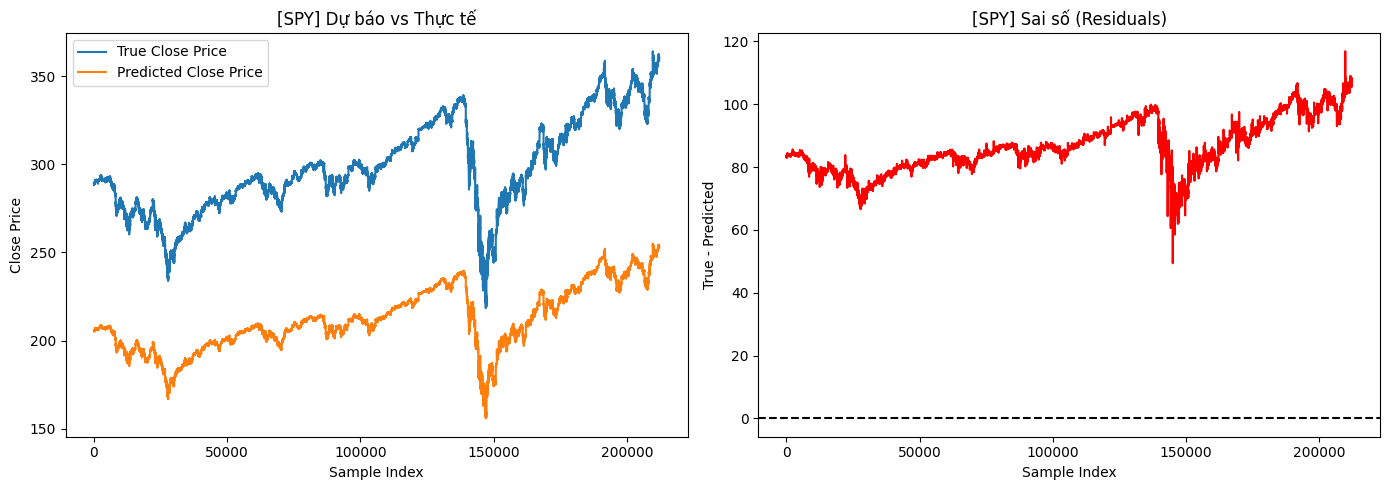

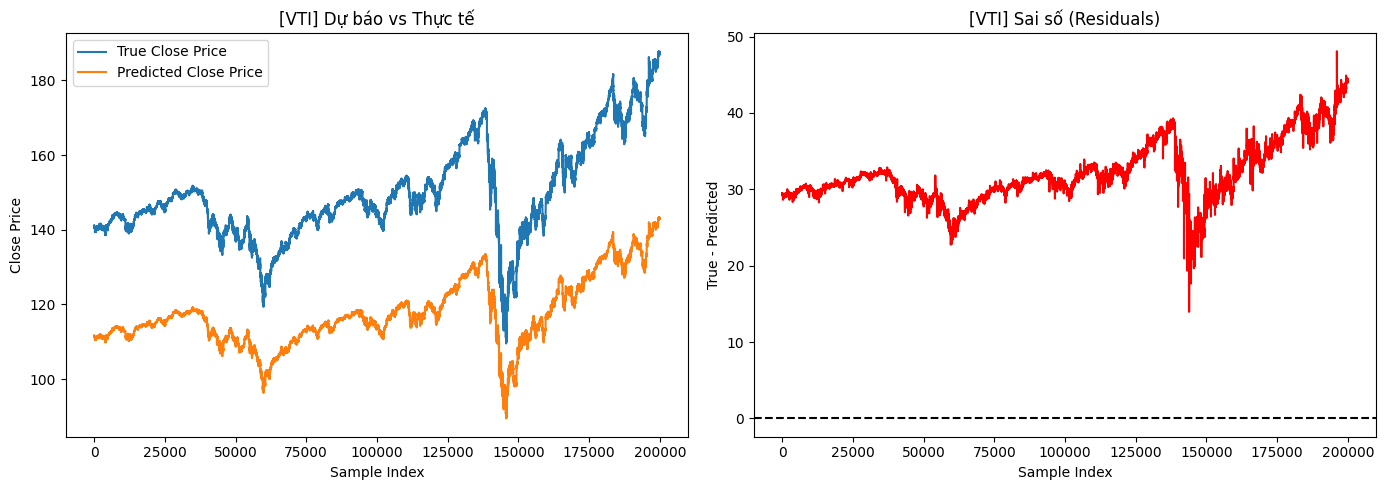

In [ ]:
# 1. Import th∆∞ vi·ªán
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# 2. H√†m ti·ªÅn x·ª≠ l√Ω (chu·∫©n h√≥a theo t·ª´ng ticker)
def preprocess_and_scale(parquet_folder_path, missing_threshold=0.8):
    files = glob.glob(f"{parquet_folder_path}/*.parquet")
    dfs = []

    for file in files:
        ticker = file.split("/")[-1].split("-")[0]
        df = pd.read_parquet(file)
        df["ticker"] = ticker
        df = df.reset_index().rename(columns={"index": "datetime"})
        dfs.append(df)

    merged_df = pd.concat(dfs).sort_values(by=["ticker", "datetime"]).reset_index(drop=True)
    merged_df["datetime"] = pd.to_datetime(merged_df["datetime"])

    le = LabelEncoder()
    merged_df["ticker_id"] = le.fit_transform(merged_df["ticker"])

    # Chu·∫©n h√≥a theo t·ª´ng ticker
    final = []
    scalers = {}
    for ticker in merged_df["ticker"].unique():
        df_ticker = merged_df[merged_df["ticker"] == ticker].copy()
        df_ticker = df_ticker.set_index("datetime").sort_index()
        df_ticker = df_ticker[~df_ticker.index.duplicated(keep="first")]

        if df_ticker["close"].isna().mean() > missing_threshold:
            continue

        df_ticker["close"] = df_ticker["close"].ffill().bfill()
        scaler = MinMaxScaler()
        df_ticker["close"] = scaler.fit_transform(df_ticker[["close"]])
        scalers[ticker] = scaler

        df_ticker = df_ticker.reset_index()
        final.append(df_ticker)

    final_df = pd.concat(final).sort_values(["ticker", "datetime"]).reset_index(drop=True)
    return final_df, le, scalers

# 3. T·∫°o sliding window
def create_sequences(data, window_size=60):
    X, y, tickers = [], [], []
    for ticker_id in data['ticker_id'].unique():
        df_ticker = data[data['ticker_id'] == ticker_id].sort_values("datetime")
        close_values = df_ticker['close'].values
        for i in range(len(close_values) - window_size):
            X.append(close_values[i:i+window_size])
            y.append(close_values[i+window_size])
            tickers.append(ticker_id)
    return np.array(X), np.array(y), np.array(tickers)

# 4. Chia train/val/test theo t·ª´ng ticker
def split_timewise(X_price, y, X_ticker, test_ratio=0.2, val_ratio=0.2):
    X_train_p, X_val_p, X_test_p = [], [], []
    X_train_t, X_val_t, X_test_t = [], [], []
    y_train, y_val, y_test = [], [], []

    for tid in np.unique(X_ticker):
        idx = np.where(X_ticker.flatten() == tid)[0]
        n = len(idx)
        if n < 10:
            continue
        n_test = int(n * test_ratio)
        n_val = int((n - n_test) * val_ratio)

        X_tkr = X_price[idx]
        y_tkr = y[idx]
        T_tkr = X_ticker[idx]

        X_train_p.append(X_tkr[:-n_test - n_val])
        y_train.append(y_tkr[:-n_test - n_val])
        X_train_t.append(T_tkr[:-n_test - n_val])

        X_val_p.append(X_tkr[-n_test - n_val:-n_test])
        y_val.append(y_tkr[-n_test - n_val:-n_test])
        X_val_t.append(T_tkr[-n_test - n_val:-n_test])

        X_test_p.append(X_tkr[-n_test:])
        y_test.append(y_tkr[-n_test:])
        X_test_t.append(T_tkr[-n_test:])

    return map(np.concatenate, [X_train_p, X_val_p, X_test_p,
                                X_train_t, X_val_t, X_test_t,
                                y_train, y_val, y_test])

# 5. Load d·ªØ li·ªáu v√† t·∫°o d·ªØ li·ªáu d·ª± ƒëo√°n
parquet_path = '/content/drive/MyDrive/TimeSeries/Demo_Data_5'  # C·∫≠p nh·∫≠t ƒë∆∞·ªùng d·∫´n
merged_df, label_encoder, scalers = preprocess_and_scale(parquet_path)
X, y, ticker_ids = create_sequences(merged_df, window_size=60)
X_price = X[..., np.newaxis]
X_ticker = ticker_ids[:, np.newaxis]

X_train_price, X_val_price, X_test_price, \
X_train_ticker, X_val_ticker, X_test_ticker, \
y_train, y_val, y_test = split_timewise(X_price, y, X_ticker)

# 6. Load m√¥ h√¨nh ƒë√£ hu·∫•n luy·ªán
model = load_model("stock_lstm_ticker.h5", compile=False)

# 7. D·ª± ƒëo√°n tr√™n t·ª´ng ticker trong t·∫≠p test
unique_tickers = np.unique(X_test_ticker)

for tid in unique_tickers:
    idx = np.where(X_test_ticker.flatten() == tid)[0]
    ticker_name = label_encoder.inverse_transform([tid])[0]
    scaler = scalers[ticker_name]

    y_true = y_test[idx]
    y_pred_ticker = model.predict({
        "price_input": X_test_price[idx],
        "ticker_input": X_test_ticker[idx]
    }, verbose=0)

    # ƒê·∫£o chu·∫©n h√≥a
    y_true_rescaled = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_rescaled = scaler.inverse_transform(y_pred_ticker).flatten()
    residuals = y_true_rescaled - y_pred_rescaled

    # V·∫Ω bi·ªÉu ƒë·ªì
    plt.figure(figsize=(14, 5))

    # D·ª± b√°o vs Th·ª±c t·∫ø
    plt.subplot(1, 2, 1)
    plt.plot(y_true_rescaled, label="True Close Price")
    plt.plot(y_pred_rescaled, label="Predicted Close Price")
    plt.title(f"[{ticker_name}] D·ª± b√°o vs Th·ª±c t·∫ø")
    plt.xlabel("Sample Index")
    plt.ylabel("Close Price")
    plt.legend()

    # Bi·ªÉu ƒë·ªì Sai s·ªë
    plt.subplot(1, 2, 2)
    plt.plot(residuals, color='red')
    plt.axhline(0, linestyle='--', color='black')
    plt.title(f"[{ticker_name}] Sai s·ªë (Residuals)")
    plt.xlabel("Sample Index")
    plt.ylabel("True - Predicted")

    plt.tight_layout()
    plt.show()


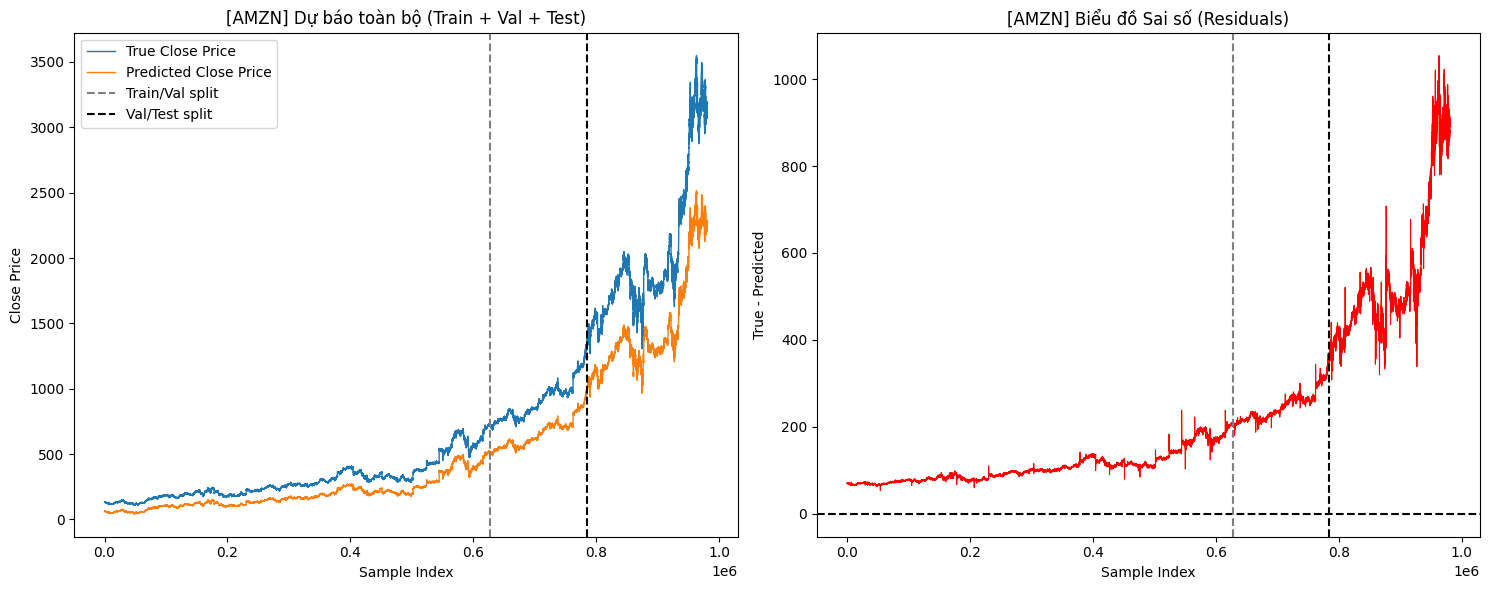

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


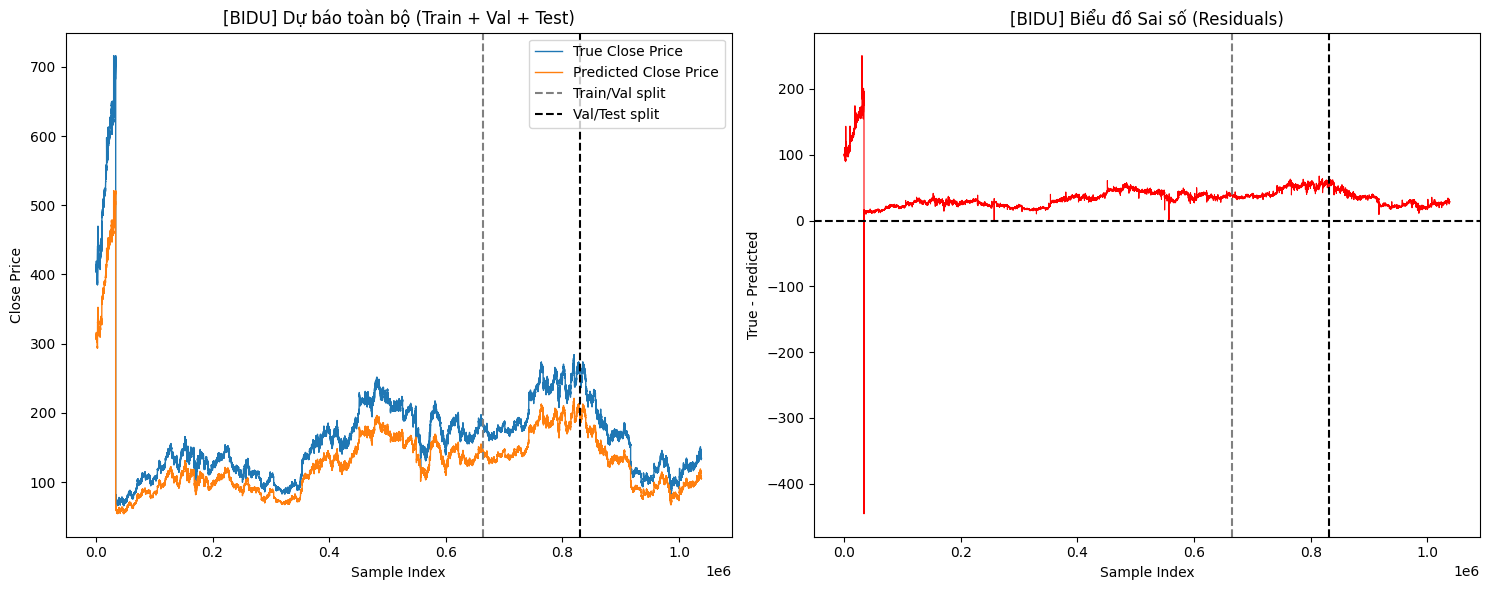

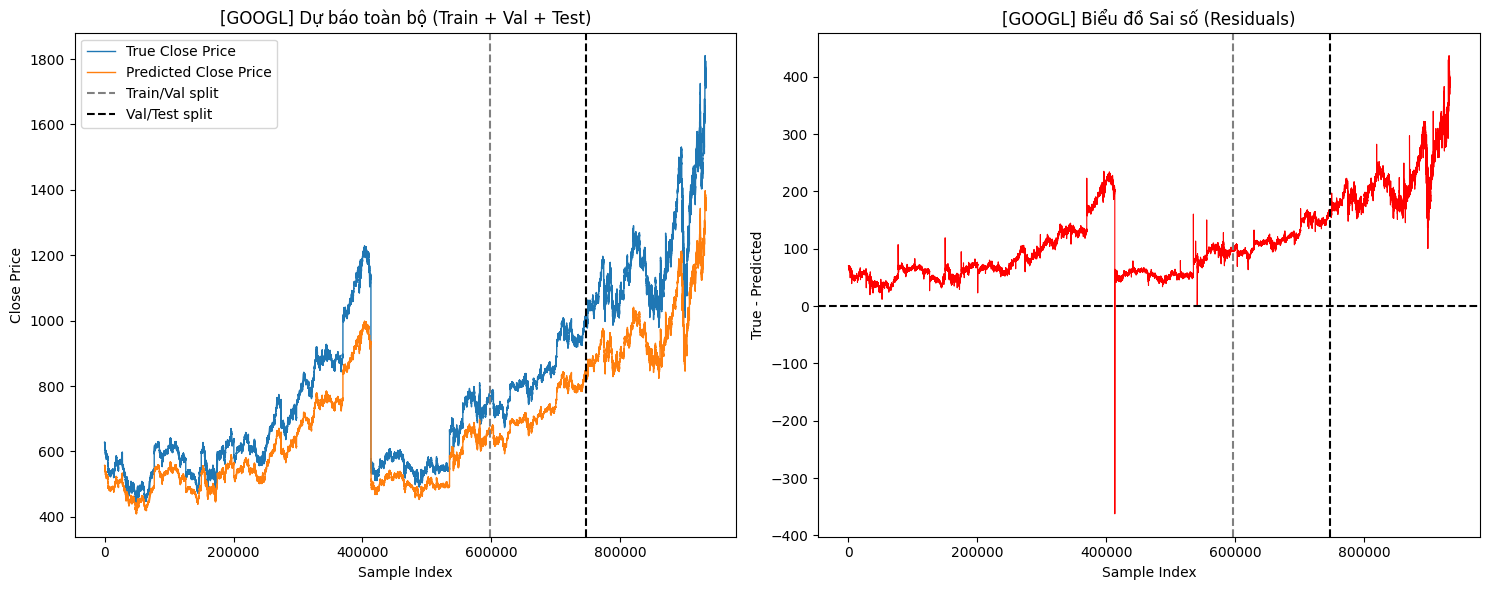

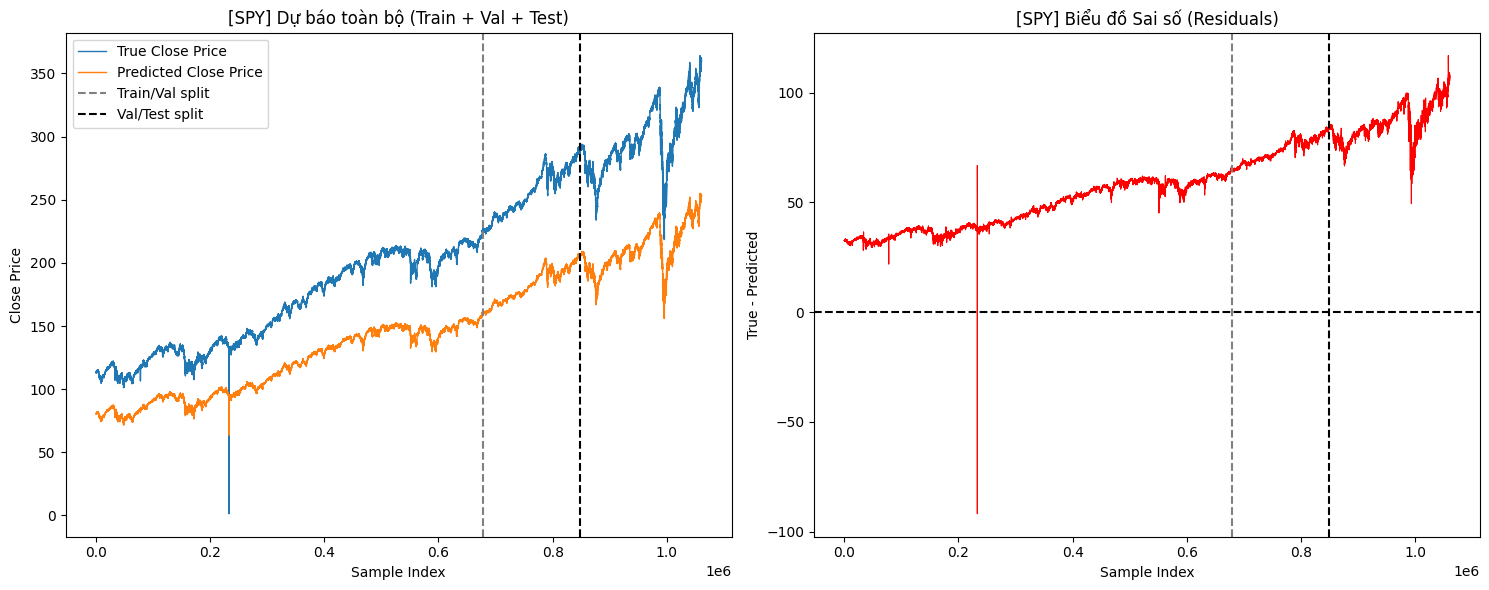

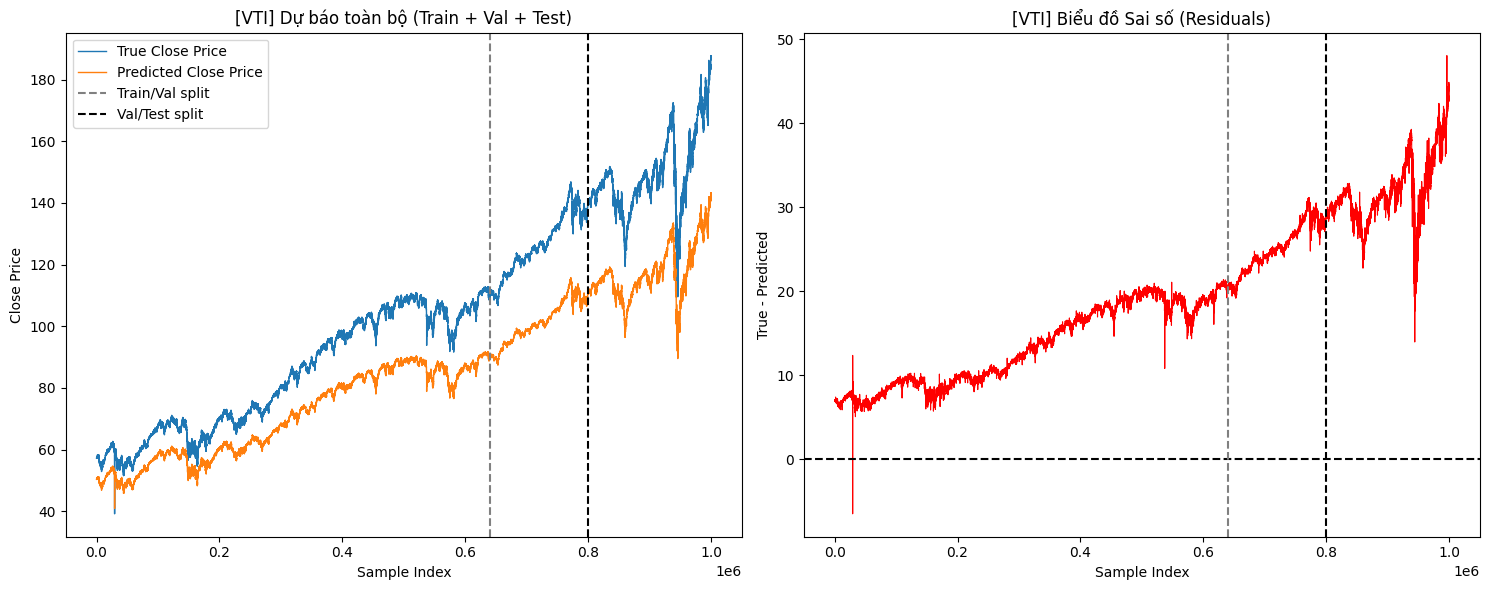

In [ ]:
for tid in np.unique(X_test_ticker):  # test c√≥ ƒë·∫ßy ƒë·ªß c√°c ticker h·ª£p l·ªá
    ticker_name = label_encoder.inverse_transform([tid])[0]
    scaler = scalers[ticker_name]

    # L·∫•y to√†n b·ªô ch·ªâ m·ª•c c·ªßa ticker n√†y ·ªü m·ªói t·∫≠p
    idx_train = np.where(X_train_ticker.flatten() == tid)[0]
    idx_val = np.where(X_val_ticker.flatten() == tid)[0]
    idx_test = np.where(X_test_ticker.flatten() == tid)[0]

    if len(idx_train) == 0 or len(idx_test) == 0:
        continue  # b·ªè qua n·∫øu thi·∫øu d·ªØ li·ªáu

    # D·ª± ƒëo√°n
    y_pred_train = model.predict({
        "price_input": X_train_price[idx_train],
        "ticker_input": X_train_ticker[idx_train]
    }, verbose=0)
    y_pred_val = model.predict({
        "price_input": X_val_price[idx_val],
        "ticker_input": X_val_ticker[idx_val]
    }, verbose=0)
    y_pred_test = model.predict({
        "price_input": X_test_price[idx_test],
        "ticker_input": X_test_ticker[idx_test]
    }, verbose=0)

    # Gh√©p l·∫°i
    y_true_all = np.concatenate([y_train[idx_train], y_val[idx_val], y_test[idx_test]])
    y_pred_all = np.concatenate([y_pred_train, y_pred_val, y_pred_test])

    # ƒê·∫£o chu·∫©n h√≥a
    y_true_rescaled = scaler.inverse_transform(y_true_all.reshape(-1, 1)).flatten()
    y_pred_rescaled = scaler.inverse_transform(y_pred_all).flatten()
    residuals = y_true_rescaled - y_pred_rescaled

    # X√°c ƒë·ªãnh index split cho bi·ªÉu ƒë·ªì
    train_len = len(idx_train)
    val_len = len(idx_val)

    # V·∫Ω bi·ªÉu ƒë·ªì
    plt.figure(figsize=(15, 6))

    # 1. Bi·ªÉu ƒë·ªì D·ª± b√°o vs Th·ª±c t·∫ø
    plt.subplot(1, 2, 1)
    plt.plot(y_true_rescaled, label="True Close Price", linewidth=1)
    plt.plot(y_pred_rescaled, label="Predicted Close Price", linewidth=1)

    plt.axvline(train_len, color='gray', linestyle='--', label='Train/Val split')
    plt.axvline(train_len + val_len, color='black', linestyle='--', label='Val/Test split')

    plt.title(f"[{ticker_name}] D·ª± b√°o to√†n b·ªô (Train + Val + Test)")
    plt.xlabel("Sample Index")
    plt.ylabel("Close Price")
    plt.legend()

    # 2. Bi·ªÉu ƒë·ªì Sai s·ªë
    plt.subplot(1, 2, 2)
    plt.plot(residuals, color='red', linewidth=0.8)
    plt.axhline(0, linestyle='--', color='black')
    plt.axvline(train_len, color='gray', linestyle='--')
    plt.axvline(train_len + val_len, color='black', linestyle='--')
    plt.title(f"[{ticker_name}] Bi·ªÉu ƒë·ªì Sai s·ªë (Residuals)")
    plt.xlabel("Sample Index")
    plt.ylabel("True - Predicted")

    plt.tight_layout()
    plt.show()


# Hu·∫•n luy·ªán m√¥ h√¨nh ban ƒë·∫ßu

In [ ]:
import pandas as pd
import numpy as np
import glob
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# --- B∆∞·ªõc 1: Kh·ªüi t·∫°o v√† l∆∞u LabelEncoder t·ª´ to√†n b·ªô d·ªØ li·ªáu ---

def fit_label_encoder_on_all_tickers(parquet_folder_path, save_path="label_encoder.pkl"):
    files = glob.glob(f"{parquet_folder_path}/*.parquet")
    tickers = []
    for file in files:
        ticker = file.split("/")[-1].split("-")[0]
        tickers.append(ticker)
    tickers = sorted(set(tickers))
    le = LabelEncoder()
    le.fit(tickers)
    with open(save_path, "wb") as f:
        pickle.dump(le, f)
    print(f"LabelEncoder fitted and saved with {len(tickers)} tickers.")
    return le

# --- B∆∞·ªõc 2: H√†m ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu t·ª´ng batch, d√πng label_encoder ƒë√£ c√≥ ---

def preprocess_and_scale_batch(parquet_folder_path, label_encoder, missing_threshold=0.8):
    files = glob.glob(f"{parquet_folder_path}/*.parquet")
    dfs = []

    for file in files:
        ticker = file.split("/")[-1].split("-")[0]
        if ticker not in label_encoder.classes_:
            print(f"Warning: Ticker {ticker} not in label encoder classes, skip.")
            continue
        df = pd.read_parquet(file)
        df["ticker"] = ticker
        df = df.reset_index().rename(columns={"index": "datetime"})
        dfs.append(df)

    merged_df = pd.concat(dfs).sort_values(by=["ticker", "datetime"]).reset_index(drop=True)
    merged_df["datetime"] = pd.to_datetime(merged_df["datetime"])
    merged_df["date"] = merged_df["datetime"].dt.date

    merged_df["ticker_id"] = label_encoder.transform(merged_df["ticker"])

    final = []
    scalers = {}

    grouped = merged_df.groupby(["ticker", "date"])
    for (ticker, date), group in grouped:
        group = group.set_index("datetime").sort_index()
        group = group[~group.index.duplicated(keep="first")]

        # T·∫°o time index chu·∫©n cho khung gi·ªù 17:30 - 23:59
        full_index = pd.date_range(f"{date} 17:30", f"{date} 23:59", freq="1min")
        group = group.reindex(full_index)

        missing_ratio = group["close"].isna().mean()
        if missing_ratio > missing_threshold:
            print("X·ª≠ l√Ω")
            continue

        group["close"] = group["close"].ffill().bfill()
        group["ticker"] = ticker
        group["ticker_id"] = label_encoder.transform([ticker])[0]
        group["date"] = date

        final.append(group.reset_index().rename(columns={"index": "datetime"}))

    final_df = pd.concat(final).sort_values(["ticker", "datetime"]).reset_index(drop=True)

    # Chu·∫©n h√≥a theo t·ª´ng ticker
    final_df["scaled_close"] = 0.0
    for ticker in final_df["ticker"].unique():
        mask = final_df["ticker"] == ticker
        scaler = StandardScaler()
        final_df.loc[mask, "scaled_close"] = scaler.fit_transform(final_df.loc[mask, ["close"]])
        scalers[ticker] = scaler

    final_df["close"] = final_df["scaled_close"]
    final_df = final_df.drop(columns=["scaled_close"])

    return final_df, scalers


# --- B∆∞·ªõc 3: T·∫°o sequence, chia d·ªØ li·ªáu, ... nh∆∞ tr∆∞·ªõc ---

def create_sequences(data, window_size=60):
    X, y, tickers = [], [], []
    for ticker_id in data['ticker_id'].unique():
        df_ticker = data[data['ticker_id'] == ticker_id].sort_values("datetime")
        close_values = df_ticker['close'].values
        for i in range(len(close_values) - window_size):
            X.append(close_values[i:i+window_size])
            y.append(close_values[i+window_size])
            tickers.append(ticker_id)
    return np.array(X), np.array(y), np.array(tickers)

def split_timewise(X_price, y, X_ticker, test_ratio=0.2, val_ratio=0.2):
    X_train_p, X_val_p, X_test_p = [], [], []
    X_train_t, X_val_t, X_test_t = [], [], []
    y_train, y_val, y_test = [], [], []

    for tid in np.unique(X_ticker):
        idx = np.where(X_ticker.flatten() == tid)[0]
        n = len(idx)
        if n < 10:
            continue
        n_test = int(n * test_ratio)
        n_val = int((n - n_test) * val_ratio)

        X_tkr = X_price[idx]
        y_tkr = y[idx]
        T_tkr = X_ticker[idx]

        X_train_p.append(X_tkr[:-n_test - n_val])
        y_train.append(y_tkr[:-n_test - n_val])
        X_train_t.append(T_tkr[:-n_test - n_val])

        X_val_p.append(X_tkr[-n_test - n_val:-n_test])
        y_val.append(y_tkr[-n_test - n_val:-n_test])
        X_val_t.append(T_tkr[-n_test - n_val:-n_test])

        X_test_p.append(X_tkr[-n_test:])
        y_test.append(y_tkr[-n_test:])
        X_test_t.append(T_tkr[-n_test:])

    return map(np.concatenate, [X_train_p, X_val_p, X_test_p,
                                X_train_t, X_val_t, X_test_t,
                                y_train, y_val, y_test])

# --- B∆∞·ªõc 4: X√¢y d·ª±ng model ---

def build_model(ticker_vocab_size, time_steps):
    embedding_dim = 8
    lstm_units = 64
    dense_units = 80
    dropout_rate = 0.2

    price_input = Input(shape=(time_steps, 1), name="price_input")
    ticker_input = Input(shape=(1,), name="ticker_input")

    ticker_embedding = Embedding(input_dim=ticker_vocab_size, output_dim=embedding_dim)(ticker_input)
    ticker_embedding_flat = Flatten()(ticker_embedding)

    x = LSTM(lstm_units, return_sequences=True)(price_input)
    x = LSTM(lstm_units)(x)
    x = Dropout(dropout_rate)(x)

    x = Concatenate()([x, ticker_embedding_flat])
    x = Dense(dense_units, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=[price_input, ticker_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.Huber(),
        metrics=['mae', tf.keras.metrics.MeanAbsolutePercentageError()]
    )
    return model

# --- V√≠ d·ª• s·ª≠ d·ª•ng ---

# Kh·ªüi t·∫°o label encoder 1 l·∫ßn duy nh·∫•t (ch·ªâ c·∫ßn ch·∫°y 1 l·∫ßn)
label_encoder_path = "label_encoder.pkl"
parquet_folder_all = "/content/drive/MyDrive/TimeSeries/Data"  # folder ch·ª©a t·∫•t c·∫£ data g·ªëc
label_encoder = fit_label_encoder_on_all_tickers(parquet_folder_all, save_path=label_encoder_path)

# Load l·∫°i khi train t·ª´ng batch (v√≠ d·ª• m·ªôt folder nh·ªè)
with open(label_encoder_path, "rb") as f:
    label_encoder = pickle.load(f)

parquet_batch_folder = "/content/drive/MyDrive/TimeSeries/Demo_Data_5"
df_batch, scalers_batch = preprocess_and_scale_batch(parquet_batch_folder, label_encoder)

X, y, ticker_ids = create_sequences(df_batch, window_size=60)
X_price = X[..., np.newaxis]
X_ticker = ticker_ids[:, np.newaxis]

X_train_price, X_val_price, X_test_price, \
X_train_ticker, X_val_ticker, X_test_ticker, \
y_train, y_val, y_test = split_timewise(X_price, y, X_ticker)

ticker_vocab_size = len(label_encoder.classes_)
time_steps = X_train_price.shape[1]



LabelEncoder fitted and saved with 1474 tickers.
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l√Ω
X·ª≠ l

In [ ]:
model = build_model(ticker_vocab_size, time_steps)

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(
    {"price_input": X_train_price, "ticker_input": X_train_ticker},
    y_train,
    validation_data=(
        {"price_input": X_val_price, "ticker_input": X_val_ticker},
        y_val
    ),
    epochs=4,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/4
52289/52289 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 601s 11ms/step - loss: 0.0013 - mae: 0.0188 - mean_absolute_percentage_error: 34.0910 - val_loss: 0.0196 - val_mae: 0.1900 - val_mean_absolute_percentage_error: 552.2496
Epoch 2/4
52289/52289 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 638s 12ms/step - loss: 1.0236e-04 - mae: 0.0062 - mean_absolute_percentage_error: 14.0817 - val_loss: 0.0163 - val_mae: 0.1694 - val_mean_absolute_percentage_error: 527.3964
Epoch 3/4
52289/52289 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 626s 12ms/step - loss: 4.6060e-04 - mae: 0.0115 - mean_absolute_percentage_error: 24.4564 - val_loss: 0.0026 - val_mae: 0.0597 - val_mean_absolute_percentage_error: 242.3562
Epoch 4/4
52289/52289 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 591s 11ms/step - loss: 6.9618e-05 - mae: 0.0054 - mean_absolute_percentage_error: 9.2837 - val_loss: 0.0057 - val_mae: 0.0951 - val_mean_absolute_perc

In [ ]:
model.save("/content/drive/MyDrive/TimeSeries/MoÃÇ hiÃÄnh/viet_model.keras")
# L∆∞u tr·ªçng s·ªë
model.save_weights("/content/drive/MyDrive/TimeSeries/M√¥ h√¨nh/viet_price.weights.h5")
with open("/content/drive/MyDrive/TimeSeries/MoÃÇ hiÃÄnh/viet_scalers.pkl", "wb") as f:
    pickle.dump(scalers_batch, f)
with open("/content/drive/MyDrive/TimeSeries/MoÃÇ hiÃÄnh/viet_label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
print("LabelEncoder saved to label_encoder.pkl")

LabelEncoder saved to label_encoder.pkl


# Ti·∫øp nhi·ªÅu

In [ ]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import load_model

# === Load m√¥ h√¨nh v√† encoder ƒë√£ l∆∞u ===
model_path = "/content/drive/MyDrive/TimeSeries/M√¥ hiÃÄnh/viet_model.keras"
scaler_path = "/content/drive/MyDrive/TimeSeries/M√¥ hiÃÄnh/viet_scalers.pkl"
encoder_path = "/content/drive/MyDrive/TimeSeries/M√¥ hiÃÄnh/viet_label_encoder.pkl"

model = tf.keras.models.load_model(model_path)

with open(encoder_path, "rb") as f:
    label_encoder = pickle.load(f)

with open(scaler_path, "rb") as f:
    old_scalers = pickle.load(f)

# === H√†m l·∫•y danh s√°ch file v√† chia batch ===
def get_batches(file_list, batch_size):
    for i in range(0, len(file_list), batch_size):
        yield file_list[i:i+batch_size]

# === H√†m x·ª≠ l√Ω d·ªØ li·ªáu gi·ªëng nh∆∞ b·∫°n vi·∫øt tr∆∞·ªõc ƒë√≥ ===
def preprocess_files(file_batch, label_encoder, old_scalers, missing_threshold=0.8):
    final = []
    new_scalers = {}

    for file in file_batch:
        ticker = os.path.basename(file).split("-")[0]
        if ticker not in label_encoder.classes_:
            print(f"‚ö†Ô∏è B·ªè qua {ticker} v√¨ kh√¥ng c√≥ trong label_encoder.")
            continue

        df = pd.read_parquet(file)
        df["ticker"] = ticker
        df = df.reset_index().rename(columns={"index": "datetime"})
        df["datetime"] = pd.to_datetime(df["datetime"])
        df["date"] = df["datetime"].dt.date
        df["ticker_id"] = label_encoder.transform([ticker])[0]

        for date, group in df.groupby("date"):
            group = group.set_index("datetime").sort_index()
            group = group[~group.index.duplicated(keep='first')]
            full_index = pd.date_range(f"{date} 17:30", f"{date} 23:59", freq="1min")
            group = group.reindex(full_index)

            missing_ratio = group["close"].isna().mean()
            if missing_ratio > missing_threshold:
                continue

            group["close"] = group["close"].ffill().bfill()
            group["ticker"] = ticker
            group["ticker_id"] = label_encoder.transform([ticker])[0]
            group["date"] = date
            final.append(group.reset_index().rename(columns={"index": "datetime"}))

    if not final:
        return None, old_scalers  # batch r·ªóng

    final_df = pd.concat(final).sort_values(["ticker", "datetime"]).reset_index(drop=True)
    final_df["scaled_close"] = 0.0

    for ticker in final_df["ticker"].unique():
        mask = final_df["ticker"] == ticker
        if ticker in old_scalers:
            scaler = old_scalers[ticker]
        else:
            scaler = StandardScaler()
            scaler.fit(final_df.loc[mask, ["close"]])
            new_scalers[ticker] = scaler
        final_df.loc[mask, "scaled_close"] = scaler.transform(final_df.loc[mask, ["close"]])

    final_df["close"] = final_df["scaled_close"]
    final_df = final_df.drop(columns=["scaled_close"])
    return final_df, new_scalers

# === H√†m t·∫°o sequence ===
def create_sequences(data, window_size=60):
    X, y, tickers = [], [], []
    for ticker_id in data['ticker_id'].unique():
        df_ticker = data[data['ticker_id'] == ticker_id].sort_values("datetime")
        close_values = df_ticker['close'].values
        for i in range(len(close_values) - window_size):
            X.append(close_values[i:i+window_size])
            y.append(close_values[i+window_size])
            tickers.append(ticker_id)
    return np.array(X), np.array(y), np.array(tickers)

# === Training fine-tune ===
def fine_tune_model_on_batch(model, df_batch):
    X, y, ticker_ids = create_sequences(df_batch, window_size=60)
    if len(X) == 0:
        print("‚ö†Ô∏è Kh√¥ng ƒë·ªß d·ªØ li·ªáu trong batch ƒë·ªÉ hu·∫•n luy·ªán.")
        return model

    X_price = X[..., np.newaxis]
    X_ticker = ticker_ids[:, np.newaxis]

    model.fit(
        {"price_input": X_price, "ticker_input": X_ticker},
        y,
        epochs=1,
        batch_size=64,
        verbose=1
    )
    return model

# === B·∫Øt ƒë·∫ßu x·ª≠ l√Ω theo batch ===
data_folder = "/content/drive/MyDrive/TimeSeries/data chuaÃÇÃân biÃ£ vaÃÄ chuÃõa train cuÃâa VieÃ£ÃÇt/ch∆∞a"
trained_folder = "/content/drive/MyDrive/TimeSeries/data chuaÃÇÃân biÃ£ vaÃÄ chuÃõa train cuÃâa VieÃ£ÃÇt/test"
all_files = glob.glob(f"{data_folder}/*.parquet")
batch_size = 5

for i, batch_files in enumerate(get_batches(all_files, batch_size)):
    print(f"\nüöÄ Batch {i+1}/{(len(all_files) + batch_size - 1)//batch_size}")
    df_batch, new_scalers = preprocess_files(batch_files, label_encoder, old_scalers)

    if df_batch is None:
        print("‚ùå Batch b·ªè qua v√¨ d·ªØ li·ªáu r·ªóng.")
        continue

    model = fine_tune_model_on_batch(model, df_batch)

    # C·∫≠p nh·∫≠t scaler
    for ticker, scaler in new_scalers.items():
        if ticker not in old_scalers:
            old_scalers[ticker] = scaler
    model.save(model_path)
    with open(scaler_path, "wb") as f:
        pickle.dump(old_scalers, f)
    print(f"üíæ ƒê√£ l∆∞u m√¥ h√¨nh v√† scaler sau Batch {i+1}.")
    for file in batch_files:
        try:
            dest_path = os.path.join(trained_folder, os.path.basename(file))
            os.rename(file, dest_path)
            print(f"üì¶ ƒê√£ chuy·ªÉn file {file} -> {dest_path}")
        except Exception as e:
            print(f"‚ùå Kh√¥ng th·ªÉ chuy·ªÉn file {file}: {e}")





üöÄ Batch 1/10
79946/79946 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 824s 10ms/step - loss: 9.7477e-06 - mae: 0.0025 - mean_absolute_percentage_error: 2.0338
üíæ ƒê√£ l∆∞u m√¥ h√¨nh v√† scaler sau Batch 1.
üì¶ ƒê√£ chuy·ªÉn file /content/drive/MyDrive/TimeSeries/data chuaÃÇÃân biÃ£ vaÃÄ chuÃõa train cuÃâa VieÃ£ÃÇt/ch∆∞a/FIS-MINUTES1.parquet -> /content/drive/MyDrive/TimeSeries/data chuaÃÇÃân biÃ£ vaÃÄ chuÃõa train cuÃâa VieÃ£ÃÇt/test/FIS-MINUTES1.parquet
üì¶ ƒê√£ chuy·ªÉn file /content/drive/MyDrive/TimeSeries/data chuaÃÇÃân biÃ£ vaÃÄ chuÃõa train cuÃâa VieÃ£ÃÇt/ch∆∞a/FITB-MINUTES1.parquet -> /content/drive/MyDrive/TimeSeries/data chuaÃÇÃân biÃ£ vaÃÄ chuÃõa train cuÃâa VieÃ£ÃÇt/test/FITB-MINUTES1.parquet
üì¶ ƒê√£ chuy·ªÉn file /content/drive/MyDrive/TimeSeries/data chuaÃÇÃân biÃ£ vaÃÄ chuÃõa train cuÃâa VieÃ£ÃÇt/ch∆∞a/FL-MINUTES1.parquet -> /content/drive/MyDrive/TimeSeries/data chuaÃÇÃân biÃ£ vaÃÄ chuÃõa train cuÃâa VieÃ£ÃÇt/test/FL-MINUTES1.parquet
üì¶ ƒê√£ 

In [ ]:
model_path = "/content/drive/MyDrive/TimeSeries/M√¥ hiÃÄnh/viet_model.keras"
scaler_path = "/content/drive/MyDrive/TimeSeries/M√¥ hiÃÄnh/viet_scalers.pkl"
# === L∆∞u model v√† scaler sau khi hu·∫•n luy·ªán xong to√†n b·ªô batch ===
model.save(model_path)
with open(scaler_path, "wb") as f:
    pickle.dump(old_scalers, f)

print("‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh v√† scaler sau khi ho√†n th√†nh hu·∫•n luy·ªán t·∫•t c·∫£ batch.")

‚úÖ ƒê√£ l∆∞u m√¥ h√¨nh v√† scaler sau khi ho√†n th√†nh hu·∫•n luy·ªán t·∫•t c·∫£ batch.
